# Lien entre consommation du premier bâtiment et optimalité du réseau 

In [2]:
from pyproj import Transformer
from shapely.ops import transform
from shapely import wkt, Point, STRtree
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon
from collections import defaultdict
import heapq


In [3]:
departements={"01":"Ain","02":"Aisne","03":"Allier","04":"Alpes-de-Haute-Provence","05":"Hautes-Alpes","06":"Alpes-Maritimes","07":"Ardèche","08":"Ardennes","09":"Ariège","10":"Aube","11":"Aude","12":"Aveyron","13":"Bouches-du-Rhône","14":"Calvados","15":"Cantal","16":"Charente","17":"Charente-Maritime","18":"Cher","19":"Corrèze","2A":"Corse-du-Sud","2B":"Haute-Corse","21":"Côte-d'Or","22":"Côtes-d'Armor","23":"Creuse","24":"Dordogne","25":"Doubs","26":"Drôme","27":"Eure","28":"Eure-et-Loir","29":"Finistère","30":"Gard","31":"Haute-Garonne","32":"Gers","33":"Gironde","34":"Hérault","35":"Ille-et-Vilaine","36":"Indre","37":"Indre-et-Loire","38":"Isère","39":"Jura","40":"Landes","41":"Loir-et-Cher","42":"Loire","43":"Haute-Loire","44":"Loire-Atlantique","45":"Loiret","46":"Lot","47":"Lot-et-Garonne","48":"Lozère","49":"Maine-et-Loire","50":"Manche","51":"Marne","52":"Haute-Marne","53":"Mayenne","54":"Meurthe-et-Moselle","55":"Meuse","56":"Morbihan","57":"Moselle","58":"Nièvre","59":"Nord","60":"Oise","61":"Orne","62":"Pas-de-Calais","63":"Puy-de-Dôme","64":"Pyrénées-Atlantiques","65":"Hautes-Pyrénées","66":"Pyrénées-Orientales","67":"Bas-Rhin","68":"Haut-Rhin","69":"Rhône","70":"Haute-Saône","71":"Saône-et-Loire","72":"Sarthe","73":"Savoie","74":"Haute-Savoie","75":"Paris","76":"Seine-Maritime","77":"Seine-et-Marne","78":"Yvelines","79":"Deux-Sèvres","80":"Somme","81":"Tarn","82":"Tarn-et-Garonne","83":"Var","84":"Vaucluse","85":"Vendée","86":"Vienne","87":"Haute-Vienne","88":"Vosges","89":"Yonne","90":"Territoire de Belfort","91":"Essonne","92":"Hauts-de-Seine","93":"Seine-Saint-Denis","94":"Val-de-Marne","95":"Val-d'Oise","971":"Guadeloupe","972":"Martinique","973":"Guyane","974":"La Réunion","976":"Mayotte"}


In [4]:
# Chemins vers les fichiers GeoPackage


#departement=input("Departement : ")
departement="27"
nom_departement=departements[departement]
print(f"Traitement du département {departement} - {nom_departement}")
buildings_file = f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/bases_de_donnees/depart_{departement}/conso_coords_{departement}.csv"
roads_file = f"/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/bases_de_donnees/depart_{departement}/final_routes_{departement}.csv"



# Charger avec le séparateur correct
df_buildings= pd.read_csv(buildings_file, sep=',', dtype=str, on_bad_lines='skip', encoding='utf-8')

roads_df = pd.read_csv(roads_file, sep=',', dtype=str, on_bad_lines='skip', encoding='utf-8')


df_buildings_copie=df_buildings[["COM_INSEE", "CHAUF_MWH", "ECS_MWH", "geom_group"]].copy()
df_buildings_copie.rename(columns={"CHAUF_MWH": "conso_ref_chauf_MWh", "ECS_MWH": "conso_ref_ecs_MWh", "COM_INSEE": "code_commune_insee", "geom_group" : "geom_groupe"}, inplace=True)

df_buildings_copie["conso_ref_tot_MWh"] = df_buildings_copie["conso_ref_chauf_MWh"].astype(float) + df_buildings_copie["conso_ref_ecs_MWh"].astype(float)

#filtrage des propriétés : enlever les Na partout
df_buildings_copie = df_buildings_copie.dropna(subset=["conso_ref_chauf_MWh", "geom_groupe", "code_commune_insee"])
#Indiquer le libellé d'une commune à partir de son code INSEE
communes_insee_file="/Users/louisedeferran/Documents/Louise/Mines/effynersys/reseau_chaleur/DHN_Potential_France_EFFINERSYS/bases_de_donnees/insee_communes_2024.csv"
communes_insee = pd.read_csv(
    communes_insee_file,
    dtype=str,
    sep='","',
    engine='python'
)

# Nettoyage des guillemets
communes_insee.columns = communes_insee.columns.str.replace('"', '')
communes_insee = communes_insee.apply(lambda c: c.str.replace('"', '', regex=False))

# Séparer TYPECOM et COM
communes_insee[['TYPECOM', 'COM']] = communes_insee['TYPECOM,COM'].str.split(',', expand=True)

# Supprimer l’ancienne colonne cassée
communes_insee = communes_insee.drop(columns=['TYPECOM,COM'])

# Vérification
print(communes_insee.columns)

# Sélection + renommage
communes_insee_copie = communes_insee[["COM", "LIBELLE"]].copy()
communes_insee_copie = communes_insee_copie.rename(
    columns={
        "COM": "code_commune_insee",
        "LIBELLE": "libelle_commune_insee"
    }
)

print(communes_insee_copie.columns)

#enlever le 0 devant les codes insee si besoin
#communes_insee_copie["code_commune_insee"] = communes_insee_copie["code_commune_insee"].str.lstrip("0")

#ajouter la colonne libellé commune dans df_buildings_copie
df_buildings_copie = df_buildings_copie.merge(
    communes_insee_copie,
    on="code_commune_insee",
    how="left"
)

# Groupement par commune
buildings_by_commune = {
    commune: df.reset_index(drop=True)
    for commune, df in df_buildings_copie.groupby("code_commune_insee")
}

print(buildings_by_commune.keys())

# Extraction des routes
roads = []  # bâtiments qui seront considérés pour le RCU
n = len(roads_df)

for road in range(n):
    properties = roads_df.iloc[road].to_dict()


    if pd.notna(properties["geom_groupe"]):
        roads.append(road)

print(len(roads), "routes ont été retenues.")
df_selected_roads = roads_df.iloc[roads]



Traitement du département 27 - Eure
Index(['REG', 'DEP', 'CTCD', 'ARR', 'TNCC', 'NCC', 'NCCENR', 'LIBELLE', 'CAN',
       'COMPARENT', 'TYPECOM', 'COM'],
      dtype='object')
Index(['code_commune_insee', 'libelle_commune_insee'], dtype='object')
dict_keys(['27001', '27002', '27003', '27004', '27005', '27006', '27008', '27009', '27010', '27011', '27012', '27013', '27014', '27015', '27016', '27017', '27018', '27019', '27020', '27021', '27022', '27023', '27025', '27026', '27027', '27028', '27031', '27032', '27033', '27034', '27035', '27036', '27037', '27038', '27039', '27040', '27042', '27043', '27044', '27045', '27046', '27047', '27048', '27049', '27050', '27051', '27052', '27053', '27054', '27055', '27056', '27057', '27058', '27059', '27061', '27062', '27063', '27064', '27065', '27066', '27067', '27068', '27069', '27070', '27071', '27072', '27073', '27074', '27075', '27076', '27077', '27078', '27079', '27081', '27082', '27083', '27085', '27089', '27090', '27091', '27094', '27095', '270

In [ ]:
all_communes_deltas = {}
all_communes_coverage = {}
all_communes_ratio_solution={}

In [161]:

liste_communes=["27467"]
for commune in liste_communes :
    print(commune)
    df_selected_buildings=buildings_by_commune.get(commune, pd.DataFrame())
    transformer = Transformer.from_crs(
        "EPSG:4326",
        "EPSG:2154",
        always_xy=True
    )

    def reproject_wkt(wkt_geom, transformer):
        try:
            geom = wkt.loads(wkt_geom)
            return transform(transformer.transform, geom)
        except Exception:
            return None
        
    df_selected_buildings["geom_proj"] = df_selected_buildings["geom_groupe"].apply(
        lambda x: reproject_wkt(x, transformer)
    )

    sorted_index_hab = np.argsort(df_selected_buildings["conso_ref_tot_MWh"])[::-1]

    df_buildings_sorted = df_selected_buildings.iloc[sorted_index_hab]
    #reset index
    df_buildings_sorted = df_buildings_sorted.reset_index(drop=True)

    E_MAX_DEF = 58.35  # MWh/an
    df_buildings_sorted_final=df_buildings_sorted[df_buildings_sorted["conso_ref_tot_MWh"]>=E_MAX_DEF]

    def get_centroid_geom(geom):
        if geom is None:
            return None
        if isinstance(geom, MultiPolygon):
            geom = max(geom.geoms, key=lambda p: p.area)
        if isinstance(geom, Polygon):
            c = geom.centroid
            return c.x, c.y
        return None

    # Fonction pour transformer LineString / MultiLineString en segments XY
    def extract_lines_xy(wkt_geom):
        try:
            geom = wkt.loads(wkt_geom)
        except Exception:
            return []  # géométrie invalide

        segments = []

        if isinstance(geom, LineString):
            coords_2d = [(c[0], c[1]) for c in geom.coords]
            segments.append(coords_2d)
        

        elif isinstance(geom, MultiLineString):
            for line in geom.geoms:
                coords_2d = [(c[0], c[1]) for c in line.coords]
                segments.append(coords_2d)

        return segments

    # Filtrer les segments de routes à l'intérieur du bounding box
    def filter_segments(segment, min_x, max_x, min_y, max_y):
        x, y = zip(*segment)  # segment est une liste de tuples (x, y)
        x = np.array(x)
        y = np.array(y)
        return ((x >= min_x) & (x <= max_x) & (y >= min_y) & (y <= max_y)).any()


        # Extraction des segments pour toutes les routes
    all_segments = []
    for geom_wkt in df_selected_roads["geom_groupe"]:
        all_segments.extend(extract_lines_xy(geom_wkt))

    # Extraire les centroids des bâtiments
    centroids = df_buildings_sorted_final["geom_proj"].apply(get_centroid_geom).dropna()
    df_buildings_sorted_final["centroids"]= centroids
    centroids = list(centroids)


    if centroids:
        centroids_x, centroids_y = zip(*centroids)
    else:
        centroids_x, centroids_y = [], []

    if centroids_x:
        buffer = 50
        min_x, max_x = min(centroids_x) - buffer, max(centroids_x) + buffer
        min_y, max_y = min(centroids_y) - buffer, max(centroids_y) + buffer
        filtered_lines = [seg for seg in all_segments if filter_segments(seg, min_x, max_x, min_y, max_y)]
    else:
        filtered_lines = all_segments



    def normalize_coordinates(coords):
        """
        Normalise les coordonnées en liste de tuples [(x, y)]
        """
        if coords is None:
            return []
        # Cas : (x, y)
        if isinstance(coords, (tuple, list)) and len(coords) == 2:
            if all(isinstance(c, (int, float)) for c in coords):
                return [tuple(coords)]

        # Cas : [(x, y), ...]
        if isinstance(coords, list):
            return [(c[0], c[1]) for c in coords if len(c) >= 2]
        

        raise ValueError(f"Format de coordonnées invalide : {coords}")

    class Node:
        def __init__(self, index: int = None, coordinates : list[tuple] = None, road_idx1 : int=None ):
            self._index = index
            self._coordinates = normalize_coordinates(coordinates) #equivalent de self.point
            if self._coordinates != [] : 
                x, y = zip(*self._coordinates)
                self._center = (np.mean(x), np.mean(y))

            self.road_idx1=road_idx1
            self.pipe=0.0
        

        @property
        def index(self):
            return self._index
        
        @index.setter
        def index(self, value):
            self._index = value

        @property
        def road_idx1(self):
            return self._road_idx1
        
        @road_idx1.setter
        def road_idx1(self, value):
            self._road_idx1 = value
        

        @property
        def center(self):
            return self._center
        
        @center.setter
        def center(self, new_center):
            self._center = new_center

        @property
        def coordinates(self):
            return self._coordinates
        
        
        @coordinates.setter
        def coordinates(self, new_coords):
            self._coordinates = normalize_coordinates(new_coords)
            x, y = zip(*self._coordinates)
            self.center = (np.mean(x), np.mean(y))
        
        @property
        def pipe(self) :
            return self._pipe
        
        @pipe.setter
        def pipe(self, new_pipe) :
            self._pipe=float(new_pipe)
        
        def calcul_distance(self, other) :
            if not isinstance(other, Node):
                raise ValueError("L'autre objet doit être une instance de la classe Node.")
            return np.linalg.norm(np.array(self.center)-np.array(other.center))
        


    class NodeBuilding(Node):
        def __init__(self, building_coordinates, heat_demand, buildings_idx, index : int = None,  coordinates : list[tuple] = None, road_idx1 : int=None) :
    
            self.building_coordinates = normalize_coordinates(building_coordinates)
            self.building_center = (np.mean([c[0] for c in self.building_coordinates]), np.mean([c[1] for c in self.building_coordinates]))
            self.buildings_idx=buildings_idx
            
            super().__init__(
                index=index,
                coordinates=coordinates, #coordonnées projetées
                road_idx1=road_idx1,
            )

            self.heat_demand = heat_demand  # MWh/an
            



        @property
        def pipe(self) :
            return self._pipe
        
        
        @pipe.setter
        def pipe(self, new_pipe) :
            self._pipe=float(new_pipe)
        
        
        #Redéfinition de la fonction égalité pour comparer deux NodesBuilding
        def __eq__(self, other):
            if not isinstance(other, NodeBuilding):
                return False
            return self.buildings_idx==other.buildings_idx and self.building_coordinates==other.building_coordinates

        
        # Permet l'utilisation comme clé de dictionnaire
        def __hash__(self):
            return hash((tuple(self.building_center), tuple(self.center), self.buildings_idx, tuple(self.coordinates),self.index ))
        def __repr__(self):
            return f"Building Node (index = {self.index}, index_building={self.buildings_idx}, center_building={self.building_center},center={self.center})"
        


    class NodeRoad(Node):
        def __init__(self, index, coordinates, road_idx1, road_idx2) :
            super().__init__(
                index=index,
                coordinates=coordinates,
                road_idx1=road_idx1
            )

            self.road_idx2=road_idx2
        
            #Redéfinition de la fonction égalité pour comparer deux NodesRoad
        def __eq__(self, other):
            if not isinstance(other, NodeRoad):
                return False
            return self.road_idx1==other.road_idx1 and self.road_idx2==other.road_idx2 and self.coordinates==other.coordinates
        
        # Permet l'utilisation comme clé de dictionnaire
        def __hash__(self):
            return hash((self.road_idx1, self.road_idx2, self.index, tuple(self.coordinates), self.center))
        def __repr__(self):
            return f"Road_node (index={self.index}, center={self.center}, road_idx1={self.road_idx1}, road_idx2={self.road_idx2})"


    class Road():
        def __init__(self, index : int, segments : list[list[tuple]]):
            self.coordinates = normalize_coordinates(segments[index])
            self.index = index
        

            if not self.coordinates:
                raise ValueError(f"Aucune coordonnée valide pour la route {index}")

            self.coords_array = np.array(self.coordinates, dtype=np.float32)
            self.linestring = LineString(self.coordinates)
            self.length = self.linestring.length


    def create_liste_nodes_buildings(df_buildings):
        liste_nodes_buildings = []
        for prov_index in range(len(df_buildings)):
            row = df_buildings.iloc[prov_index]
            building_coordinates = row["centroids"]
            heat_demand = row["conso_ref_tot_MWh"]
            building_idx=len(liste_nodes_buildings)
            liste_nodes_buildings.append(
                NodeBuilding(building_coordinates, heat_demand, building_idx)
            )
        return liste_nodes_buildings

    def create_roads(filtered_lines):
        liste_roads = []
        for i in range(len(filtered_lines)):
            liste_roads.append(Road(index=i, segments=filtered_lines))
        return liste_roads

    liste_nodes_buildings = create_liste_nodes_buildings(df_buildings_sorted_final)
    print(f"Nombre de bâtiments : {len(liste_nodes_buildings)}")

    liste_roads = create_roads(filtered_lines)
    print(f"Nombre de routes : {len(liste_roads)}")

    PRECISION = 1

    def normalize_point(pt):
        return (
            round(pt[0], PRECISION),
            round(pt[1], PRECISION)
        )


    lines = [r.linestring for r in liste_roads]
    tree = STRtree(lines)

    liste_intersection_points=[]
    road_intersections = {r.index: [] for r in liste_roads} #dictionnaire de la liste des intersections entre les routes

    for road in liste_roads:
        line = road.linestring
        idx = road.index

        candidate_indices = tree.query(line) #ce sont les mêmes indices que dans lines
        for other_idx in candidate_indices:
            if other_idx <= idx:
                continue  # évite doublons

            other_line = lines[other_idx]

            if not line.intersects(other_line):
                continue

            inter = line.intersection(other_line) 

            if inter.is_empty:
                continue

            if inter.geom_type == "Point":
                #pt=normalize_point((inter.x, inter.y))
                pt = (inter.x, inter.y)
                road_point = NodeRoad(
                    index=len(liste_intersection_points),
                    coordinates=[pt],
                    road_idx1=idx,
                    road_idx2=other_idx
                )
                liste_intersection_points.append(road_point)
                road_intersections[idx].append(road_point.index)
                road_intersections[other_idx].append(road_point.index)


    nb_roads_intersections=len(liste_intersection_points)
    #complexité globale en nlog(n)
    # Projection des bâtiments sur les routes
    for building in liste_nodes_buildings:

        building_point = Point(building.building_center)

        nearest_idx = tree.nearest(building_point)
        nearest_line = lines[nearest_idx]

        # Projection orthogonale
        projected_point = nearest_line.interpolate(
            nearest_line.project(building_point)
        )
        pt = normalize_point((projected_point.x, projected_point.y))
        #pt = (projected_point.x, projected_point.y)
        #modifier très légèrement la coordonnée pour éviter les doublons
        if len(liste_intersection_points)>0 :
            if pt in [b.center for b in liste_intersection_points[:nb_roads_intersections]]:
                pt = (pt[0] + 10**-1, pt[1] + 10**-1)

        building.coordinates=[pt] #coordonnées projetées
        pipe=building_point.distance(projected_point)
        building.pipe=pipe

        building.road_idx1=nearest_idx
        building.index=len(liste_intersection_points)


        liste_intersection_points.append(building)
        road_intersections[nearest_idx].append(building.index)






    for road_idx, intersections in road_intersections.items():
        line = liste_roads[road_idx].linestring
        intersections.sort(
            key=lambda ip: line.project(Point(liste_intersection_points[ip].center))
        )
        road_intersections[road_idx] = intersections  



    index_maps = {
        road_idx: {ip_idx: i for i, ip_idx in enumerate(intersections)}
        for road_idx, intersections in road_intersections.items()
    }

    #Donne un dictionnaire avec pour clé l'index d'une route et pour valeur un dictionnaire
    #avec pour clé l'index d'un point d'intersection et pour valeur l'indice de ce point 
    #dans la liste triée des intersections de cette route


    def add_voisin(ip_idx, voisin_idx):
        if voisin_idx != ip_idx:
            voisins[ip_idx].add(voisin_idx)
            voisins[voisin_idx].add(ip_idx)



    #Calcul des voisins 
    voisins={ip.index : set() for ip in liste_intersection_points} # dictionnaire des voisins pour chaque point d'intersection, on évite les doublons avec le set

    for i, intersection_point in enumerate(liste_intersection_points):
        road_idx1= intersection_point.road_idx1

        if isinstance(intersection_point, NodeRoad) :
            road_idx2=intersection_point.road_idx2
        else :
            road_idx2 = None


        voisins_pot1 = road_intersections[road_idx1] #liste des index des ip triés dans l'ordre
        voisins_pot2 = road_intersections[road_idx2] if road_idx2 is not None else []

        indice1 = index_maps[road_idx1][intersection_point.index] #place du voisin potentiel dans la liste triée de road_idx1
        indice2 = index_maps[road_idx2][intersection_point.index] if road_idx2 is not None else None

    

        if indice1>0 :
            add_voisin(intersection_point.index, voisins_pot1[indice1-1])
            if indice1<len(voisins_pot1)-1 :
                add_voisin(intersection_point.index, voisins_pot1[indice1+1])
        if indice2 is not None :
            if indice2>0 :
                add_voisin(intersection_point.index, voisins_pot2[indice2-1])
            if indice2<len(voisins_pot2)-1 :
                add_voisin(intersection_point.index, voisins_pot2[indice2+1])

    voisins = {ip: list(vs) for ip, vs in voisins.items()} #conversion des sets en listes d'index d'intersection points, 
                                            #résultat = dictionnaire avec pour clé IntersectionPoint et pour valeur la liste des index de ses voisins IntersectionPoint




    class Graph:

        def __init__(self, liste_nodes_buildings,road_intersections, liste_intersection_points, voisins, idx_ip_plant):
            self.liste_nodes_buildings = liste_nodes_buildings
            self.road_intersections = road_intersections
            self.liste_intersection_points=liste_intersection_points
            self.voisins=voisins

            self.ip_plant=liste_nodes_buildings[idx_ip_plant] #le powerplant est le premier bâtiment de la liste_nodes_buildings par defaut
        

            self.distances_to_plant={self.ip_plant.index : 0.0} #dictionnaire des distances entre le powerplant et chaque point d'intersection

            self.nb_buildings=len(liste_nodes_buildings) #on compte le powerplant

            for i in range(len(self.liste_intersection_points)): #on initialise les distances à l'infini sauf pour le powerplant
                if i != self.ip_plant.index :
                    self.distances_to_plant[i]=np.inf
            
            self.predecessors=defaultdict(set) #dictionnaire des prédécesseurs pour chaque point d'intersection

            self.total_heat_demand=sum([b.heat_demand for b in liste_nodes_buildings])







        @property
        def ip_plant(self) :
            return self._ip_plant
        
        @ip_plant.setter
        def ip_plant(self, new_ip) :
            self._ip_plant=new_ip
        
        

        def dijkstra(self, verbose=False):
            pq = [(0.0, self.ip_plant.index)]
            self.distances_to_plant[self.ip_plant.index] = 0.0

            while pq:
                current_dist, ip_index = heapq.heappop(pq)

                ip = self.liste_intersection_points[ip_index]
                if isinstance(ip, NodeBuilding):
                    if verbose : 
                        print(f"Le building à étudier est {ip_index}")
                else :
                    if verbose :
                        print(f"La route à étudier est {ip_index}")

                if (current_dist + ip.pipe > self.distances_to_plant[ip.index] and ip.index != self.ip_plant.index):
                    continue
                if (current_dist + ip.pipe == self.distances_to_plant[ip.index] and len(self.voisins[ip.index]) == 1 ):
                    continue    
                
                for v_idx in self.voisins[ip.index]:

                    if len(self.voisins[v_idx]) == 0 : #certaines routes sont isolées, on les ignore
                        continue
                    

                    v=self.liste_intersection_points[v_idx]

                    d = current_dist + v.pipe + v.calcul_distance(ip)

                    if d < self.distances_to_plant[v.index] and self.predecessors[v.index] != {ip.index}: #éviter les cycles infinis
                        self.predecessors[v.index] = {ip.index}
                        self.distances_to_plant[v.index] = d
                        if verbose:
                            print(f" Mise à jour : distance au plant pour le noeud {v.index} = {d:.2f} m, prédécesseur = {ip.index}")
                        heapq.heappush(pq, (d - v.pipe, v.index))
                    

        

        
        def distances_b_to_plant(self):
            return {
                ip.index: self.distances_to_plant[ip.index]
                for ip in self.liste_intersection_points
                if isinstance(ip, NodeBuilding)
            }
        
        def distances_b_to_plant_sorted(self):
            distances = self.distances_b_to_plant()
            return dict(
                sorted(
                    distances.items(),
                    key=lambda item: item[1]
                )
            )
        
        def building_ip(self, idx):
            for ip in self.liste_intersection_points:
                if isinstance(ip, NodeBuilding) and ip.index == idx:
                    return ip
            return None



        def distance_dijkstra_to_network(self, idx_building, network_nodes_idx, verbose=False):
            """
            Longueur réelle du chemin Dijkstra à construire
            entre un bâtiment et le réseau existant.
            """

            length = 0.0
            current = idx_building
            visited = set()

            while current not in network_nodes_idx:

                if current in visited:
                    if verbose : 
                        print(f"Cycle détecté pour {idx_building}")
                        print()
                    return np.inf
                
                visited.add(current)

                preds = self.predecessors.get(current)
                if not preds:
                    if verbose : 
                        print(f"Bâtiment {idx_building} non atteignable depuis le réseau.")
                    return np.inf

                # arbre Dijkstra → un seul prédécesseur effectif
                p = next(iter(preds))

                ip_current = self.liste_intersection_points[current]
                ip_pred = self.liste_intersection_points[p]

                length += ip_current.calcul_distance(ip_pred)
                current = p

            return length


        
        
        def connected_buildings(self, verbose=False):
            """
            Connexion basée sur la distance géométrique
            au nœud du réseau déjà construit le plus proche,
            avec mise à jour incrémentale du réseau.
            """

            connected = [self.ip_plant.index]
            #a_parcourir = [b for b in distances_buildings.keys() if b != self.ip_plant.index ]

            a_parcourir=[building.index for building in self.liste_nodes_buildings if building.index != self.ip_plant.index]

            heat_demand_total = self.ip_plant.heat_demand
            network_length = self.ip_plant.pipe  # longueur initiale (connexion du plant)
            added = True

            # Réseau utilisé (ensemble d'indices)
            network_nodes_idx = {self.ip_plant.index}
                                # Mise à jour incrémentale du réseau
            stack = [self.ip_plant.index]
            while stack:
                idx = stack.pop()
                if idx in network_nodes_idx:
                    continue
                network_nodes_idx.add(idx)
                for p in self.predecessors.get(idx, []):
                    stack.append(p)

            while added:
                added = False

                for idx_building in list(a_parcourir):

                    building = self.building_ip(idx_building)

                    d_to_network = self.distance_dijkstra_to_network(
                        idx_building, network_nodes_idx
                    )
                    if verbose :
                        print(f"Distance Dijkstra bâtiment {idx_building} au réseau : {d_to_network:.2f} m")
                    if not np.isfinite(d_to_network):
                        continue



                    ratio = (
                        heat_demand_total + building.heat_demand
                    ) / (
                        network_length + d_to_network
                    )

                    if verbose:
                        print(
                            f"Bâtiment {idx_building} | "
                            f"Predecesseurs = {self.predecessors.get(idx_building, set())} | "
                            f"d_reseau = {d_to_network:.2f} m | "
                            f"ratio = {ratio:.2f}"
                        )

                    if ratio > 1.5: #MWh/m/an
                        # Connexion acceptée
                        connected.append(idx_building)
                        a_parcourir.remove(idx_building)

                        heat_demand_total += building.heat_demand
                        network_length += d_to_network
                        added = True

                        # Mise à jour incrémentale du réseau
                        stack = [idx_building]
                        while stack:
                            idx = stack.pop()
                            if idx in network_nodes_idx:
                                continue
                            network_nodes_idx.add(idx)
                            for p in self.predecessors.get(idx, []):
                                stack.append(p)

                        if verbose:
                            print(f"→ Bâtiment {idx_building} connecté.")

            return connected, network_length, network_nodes_idx, heat_demand_total

    dico_results={idx_ip_plant: {
        "connected_buildings": 0,
        "total_network_length_m": 0.0,
        "total_heat_demand_MWh_per_year": 0.0,
        "percentage_heat_demand_connected": 0.0,
        "percentage_buildings_connected": 0.0
    } for idx_ip_plant in range(len(liste_nodes_buildings))}


    for idx_ip_plant in range(len(liste_nodes_buildings)) : 

        #print(f"Calculs pour le powerplant index {idx_ip_plant}")
        G=Graph(liste_nodes_buildings, road_intersections, liste_intersection_points, voisins, idx_ip_plant=idx_ip_plant)

        G.dijkstra(verbose=False)
        distances_buildings = G.distances_b_to_plant()

        connected, network_length, network_nodes_idx, heat_demand = G.connected_buildings(verbose=False)
        dico_results[idx_ip_plant]["connected_buildings"]=len(connected)
        dico_results[idx_ip_plant]["total_network_length_m"]=network_length
        dico_results[idx_ip_plant]["total_heat_demand_MWh_per_year"]=heat_demand
        dico_results[idx_ip_plant]["percentage_heat_demand_connected"] = heat_demand / G.total_heat_demand *100 if G.total_heat_demand > 0 else 0    
        dico_results[idx_ip_plant]["percentage_buildings_connected"] = len(connected) / G.nb_buildings *100 if G.nb_buildings > 0 else 0 

    best_idx_plant = max(dico_results, key=lambda idx: dico_results[idx]["percentage_heat_demand_connected"])
    best_coverage = dico_results[best_idx_plant]

    delta_coverage=[]
    coverage=[]
    ratio_solution=[]
    n=min(15, len(dico_results))

    for i in range(n) :
        delta_coverage.append( dico_results[i]["percentage_heat_demand_connected"] - best_coverage["percentage_heat_demand_connected"])
        coverage.append(dico_results[i]["percentage_heat_demand_connected"] )
        ratio_solution.append(dico_results[i]["percentage_heat_demand_connected"]/best_coverage["percentage_heat_demand_connected"])
    all_communes_deltas[commune]=delta_coverage
    all_communes_coverage[commune]=coverage
    all_communes_ratio_solution[commune]=ratio_solution



27467


/var/folders/7q/1g8c6vbj47ndz60jzpr7xn7h0000gn/T/ipykernel_6300/1392068154.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buildings_sorted_final["centroids"]= centroids


Nombre de bâtiments : 221
Nombre de routes : 1487


In [162]:
print(all_communes_deltas)
print(all_communes_coverage)
print(all_communes_ratio_solution)


{'01004': [np.float64(-21.271475366000395), np.float64(-44.610825144283254), np.float64(-68.79247721550013), np.float64(-60.17559106000846), np.float64(-18.033736657976235), np.float64(-17.995855337923658), np.float64(-44.64202152550303), np.float64(-20.37569356240389), np.float64(-76.45341711790003), np.float64(-14.515230518974079), np.float64(-2.6360942130712743), np.float64(-44.840341377543055), np.float64(-21.487621721594564), np.float64(-68.34904293959043), np.float64(-25.663480179156352)], '02237': [np.float64(0.0), np.float64(0.0), np.float64(-3.964134025483702), np.float64(-57.99905615856535), np.float64(0.0), np.float64(-62.24634261444076), np.float64(0.0), np.float64(-63.09579990561585), np.float64(-3.964134025483702), np.float64(-64.13402548371873), np.float64(-64.22840962718263), np.float64(0.0), np.float64(-64.51156205757432), np.float64(-57.99905615856535), np.float64(-65.36101934874941)], '04145': [np.float64(-14.433962264150928), np.float64(-11.132075471698109), np.floa

In [ ]:
{'01004': [np.float64(-21.271475366000395), np.float64(-44.610825144283254), np.float64(-68.79247721550013), np.float64(-60.17559106000846), np.float64(-18.033736657976235), np.float64(-17.995855337923658), np.float64(-44.64202152550303), np.float64(-20.37569356240389), np.float64(-76.45341711790003), np.float64(-14.515230518974079), np.float64(-2.6360942130712743), np.float64(-44.840341377543055), np.float64(-21.487621721594564), np.float64(-68.34904293959043), np.float64(-25.663480179156352)], '02237': [np.float64(0.0), np.float64(0.0), np.float64(-3.964134025483702), np.float64(-57.99905615856535), np.float64(0.0), np.float64(-62.24634261444076), np.float64(0.0), np.float64(-63.09579990561585), np.float64(-3.964134025483702), np.float64(-64.13402548371873), np.float64(-64.22840962718263), np.float64(0.0), np.float64(-64.51156205757432), np.float64(-57.99905615856535), np.float64(-65.36101934874941)], '04145': [np.float64(-14.433962264150928), np.float64(-11.132075471698109), np.float64(-57.86163522012578), np.float64(-11.132075471698109), np.float64(-10.094339622641499), np.float64(-11.132075471698109), np.float64(-13.176100628930804), np.float64(0.0), np.float64(-67.57861635220125), np.float64(-64.90566037735849), np.float64(-57.86163522012578), np.float64(-67.98742138364778), np.float64(-13.176100628930804), np.float64(-64.90566037735849), np.float64(-68.45911949685534)], '06152': [np.float64(-38.47389558232932), np.float64(-15.582329317269078), np.float64(-6.586345381526101), np.float64(-18.68213595121226), np.float64(-33.35415737022163), np.float64(-17.402945113788487), np.float64(-7.88636025583817), np.float64(-35.26996876394467), np.float64(-6.610144280827015), np.float64(-19.443700728841296), np.float64(-42.33824185631415), np.float64(-10.730328722296598), np.float64(-44.68540829986613), np.float64(-44.1231593038822), np.float64(-44.721106648817496)], '07229': [np.float64(-3.5842293906810028), np.float64(-66.72640382317802), np.float64(-3.5842293906810028), np.float64(-3.7634408602150557), np.float64(-6.332138590203101), np.float64(0.0), np.float64(-73.11827956989248), np.float64(-75.20908004778973), np.float64(-3.5842293906810028), np.float64(-75.86618876941458), np.float64(-3.7634408602150557)], '09107': [np.float64(0.0), np.float64(-30.141843971631204), np.float64(-33.33333333333333), np.float64(-34.219858156028366), np.float64(-35.46099290780142)], '11041': [np.float64(0.0), np.float64(-2.040816326530617), np.float64(-9.38775510204082)], '13041': [np.float64(0.0), np.float64(-14.768045374284338), np.float64(-18.641981914495158), np.float64(-14.768045374284338), np.float64(-13.082561934827973), np.float64(-19.63721975493606), np.float64(-12.413719300123066), np.float64(-2.439937931403499), np.float64(-1.1504093316924369), np.float64(-3.2800042805928626), np.float64(-20.043876076836643), np.float64(-12.397667076890148), np.float64(-20.311413130718606), np.float64(-5.521964792123708), np.float64(-19.589063085237306)], '15001': [np.float64(0.0), np.float64(-25.471963933502398), np.float64(-27.078050154973234), np.float64(-28.176951253874332), np.float64(-26.514511129895748), np.float64(-28.4305438151592), np.float64(-28.4305438151592), np.float64(-28.4305438151592), np.float64(0.0), np.float64(-28.99408284023669), np.float64(-29.19132149901381), np.float64(0.0), np.float64(0.0), np.float64(-29.5294449140603), np.float64(-2.5641025641025657)], '19261': [np.float64(-13.122972574461816), np.float64(-7.696844588616933), np.float64(0.0), np.float64(-19.964612208787972), np.float64(-13.122972574461816), np.float64(-29.991153052196996), np.float64(-15.452668829253913), np.float64(-12.415216750221177), np.float64(-12.415216750221177), np.float64(-30.757888528457688), np.float64(-7.696844588616933), np.float64(-12.798584488351523), np.float64(-15.836036567384255), np.float64(-3.1554113830728454), np.float64(-12.798584488351523)], '21166': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.5273311897106083), np.float64(-1.3365851000054505), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.5273311897106083), np.float64(0.0), np.float64(0.0), np.float64(-1.5273311897106083), np.float64(-1.039566188893133)], '22213': [np.float64(0.0), np.float64(-12.565445026178015), np.float64(-13.752181500872606), np.float64(-7.9581151832460755), np.float64(-20.802792321116932), np.float64(-7.9581151832460755), np.float64(0.0), np.float64(-21.012216404886566), np.float64(-23.560209424083773), np.float64(-7.9581151832460755), np.float64(-23.734729493891802), np.float64(0.0), np.float64(0.0), np.float64(-24.502617801047123), np.float64(-25.061082024432814)], '24352': [np.float64(-2.5075225677031057), np.float64(-19.25777331995988), np.float64(-28.545636910732195), np.float64(-29.157472417251753), np.float64(-19.25777331995988), np.float64(-13.350050150451356), np.float64(-19.287863590772314), np.float64(-28.43530591775326), np.float64(-34.062186559679034), np.float64(-30.942828485456367), np.float64(-0.8525576730190565), np.float64(-19.287863590772314), np.float64(-30.942828485456367), np.float64(-2.7783350050150446), np.float64(-33.90170511534604)], '25031': [np.float64(-9.259164578966207), np.float64(-27.186972749118056), np.float64(-34.54164323329414), np.float64(-9.606830615062123), np.float64(-8.200828263203647), np.float64(-76.54276803517563), np.float64(-82.63970550641649), np.float64(-35.50283756838284), np.float64(-49.00301651413672), np.float64(-6.350017894575387), np.float64(-12.127409376757498), np.float64(-12.07628201850811), np.float64(-76.36637864921519), np.float64(-82.63970550641649), np.float64(-87.05710925916458)], '30034': [np.float64(-3.4230544177881868), np.float64(-5.266237565827968), np.float64(-29.37390286717379), np.float64(-16.47162083089526), np.float64(-31.0122878876536), np.float64(-12.170860152135752), np.float64(-28.115857226448217), np.float64(-30.280866003510827), np.float64(-28.115857226448217), np.float64(-20.12873025160913), np.float64(-33.46986541837332), np.float64(-31.07080163838502), np.float64(-33.82094792276185), np.float64(-31.07080163838502), np.float64(-34.11351667641896)], '31150': [np.float64(-13.133867982726706), np.float64(-41.153608883405305), np.float64(-13.553362122146822), np.float64(-41.153608883405305), np.float64(-52.17149907464528), np.float64(-11.813695249845772), np.float64(0.0), np.float64(-12.640345465761875), np.float64(-52.17149907464528), np.float64(-1.1906230721776652), np.float64(-53.7446020974707), np.float64(-55.60764959901295), np.float64(-55.619987661937074), np.float64(-11.4188772362739), np.float64(-53.7446020974707)], '33055': [np.float64(0.0), np.float64(-39.46980854197349), np.float64(0.0), np.float64(-56.25920471281296)], '37109': [np.float64(-15.780211184982399), np.float64(-17.843175596402034), np.float64(-19.456394211967147), np.float64(-17.207665232694563), np.float64(-13.76613218615565), np.float64(-18.420023464998042), np.float64(-14.851388345717636), np.float64(-5.1622995698083685), np.float64(-5.1622995698083685), np.float64(-8.08564724286273), np.float64(-17.980054751662102), np.float64(-17.38365271802894), np.float64(-20.786077434493546), np.float64(-20.658975361752052), np.float64(-18.244035979663668)], '39478': [np.float64(-2.165890887742691), np.float64(-0.9078710110286323), np.float64(-1.1385079884262126), np.float64(-2.796997525894227), np.float64(-1.4907535539061456), np.float64(0.0), np.float64(-1.2957604730154628), np.float64(-98.13393718287415), np.float64(-95.34742315595253), np.float64(-0.9686753050698087), np.float64(-0.9686753050698087), np.float64(-1.0756069945905153), np.float64(0.0), np.float64(-0.9686753050698087), np.float64(-95.34742315595253)], '40207': [np.float64(-42.34583872358775), np.float64(-2.7598102630444146), np.float64(-2.7598102630444146), np.float64(0.0), np.float64(0.0), np.float64(-50.625269512721), np.float64(-50.71151358344114), np.float64(-47.951703320396724), np.float64(-45.01940491591203), np.float64(-52.30702889176369), np.float64(-7.546356188012076), np.float64(-7.546356188012076), np.float64(-52.910737386804655), np.float64(-48.94351013367831), np.float64(0.0)], '41151': [np.float64(-4.505258126195031), np.float64(-4.505258126195031), np.float64(0.0), np.float64(0.0), np.float64(-5.867590822179736), np.float64(-5.867590822179736), np.float64(-1.553537284894844), np.float64(-1.553537284894844), np.float64(-2.629063097514333), np.float64(-2.629063097514333), np.float64(-3.0114722753346115), np.float64(-3.0114722753346115), np.float64(-5.258126195028694), np.float64(-5.258126195028694), np.float64(-3.6806883365200775)], '43032': [np.float64(-12.829324169530354), np.float64(0.0), np.float64(-6.758304696449024), np.float64(0.0), np.float64(-17.18213058419244), np.float64(-11.282932416953035), np.float64(-11.282932416953035), np.float64(-19.702176403207332), np.float64(-20.6758304696449), np.float64(-20.904925544100802), np.float64(-6.758304696449024), np.float64(0.0), np.float64(-6.758304696449024), np.float64(-17.983963344788087), np.float64(-17.983963344788087)], '45338': [np.float64(-22.687609075043625), np.float64(-32.028588049530455), np.float64(-29.186404055513997), np.float64(-23.277653120585054), np.float64(-33.200365661098644), np.float64(-29.053436383279312), np.float64(-6.723177927366404), np.float64(-13.5793235269675), np.float64(-31.197540098063655), np.float64(-31.197540098063655), np.float64(-13.5793235269675), np.float64(-31.322197290783674), np.float64(-35.535610404720344), np.float64(-31.363749688357014), np.float64(-22.687609075043625)], '46108': [np.float64(0.0), np.float64(-4.214559386973178), np.float64(-5.363984674329501), np.float64(-8.237547892720306), np.float64(-10.919540229885058), np.float64(-11.494252873563218)], '50551': [np.float64(-10.579008843650925), np.float64(-10.31203070248624), np.float64(-6.641081261471712), np.float64(-13.649257467044876), np.float64(-12.180877690639079), np.float64(-11.68029367595527), np.float64(-2.953445686634396), np.float64(-9.244118137827456), np.float64(-11.68029367595527), np.float64(-11.68029367595527), np.float64(-11.68029367595527), np.float64(-9.96162189220756), np.float64(-20.457200066744534), np.float64(-15.818454864008004), np.float64(-9.96162189220756)], '51172': [np.float64(-9.599840050269918), np.float64(-1.496672474365198), np.float64(-1.4338350804032984), np.float64(-7.243437776698755), np.float64(-4.552854817057508), np.float64(-4.918454200108542), np.float64(-3.1275884721944465), np.float64(-2.1421838850646964), np.float64(-1.271029105138382), np.float64(0.0), np.float64(-7.243437776698755), np.float64(-17.30884579132274), np.float64(-4.081574362343261), np.float64(-5.618234269229674), np.float64(-0.17423095598526572)], '53066': [np.float64(0.0), np.float64(-10.319917440660472), np.float64(-13.31269349845201), np.float64(-15.2734778121775), np.float64(-15.376676986584105), np.float64(-16.615067079463365), np.float64(-17.23426212590299), np.float64(-18.05985552115583), np.float64(-18.575851393188852)], '58303': [np.float64(-2.8280732286890498), np.float64(-18.528063188192384), np.float64(-69.34301683456609), np.float64(-9.478228856387446), np.float64(-65.58787108002277), np.float64(-9.073262157368063), np.float64(-11.586733157066845), np.float64(-9.324274574115606), np.float64(-7.071856487834268), np.float64(-13.902741055590887), np.float64(-5.251179758358717), np.float64(-17.018641855483786), np.float64(-4.822785233776244), np.float64(-66.96007229157603), np.float64(-69.00833361223603)], '59086': [np.float64(0.0), np.float64(-30.667144906743186), np.float64(0.0), np.float64(0.0), np.float64(-36.15494978479197), np.float64(-41.06886657101865), np.float64(-41.5351506456241), np.float64(-41.75035868005739), np.float64(-41.75035868005739), np.float64(-41.85796269727403), np.float64(-42.073170731707314), np.float64(-42.144906743185075), np.float64(-36.15494978479197), np.float64(-42.25251076040172), np.float64(-42.32424677187948)], '60100': [np.float64(0.0), np.float64(-48.42300556586271), np.float64(-16.69758812615956), np.float64(0.0), np.float64(-54.17439703153989)], '63040': [np.float64(-8.079430043959384), np.float64(-0.6972866454449047), np.float64(-29.695316052751256), np.float64(-30.817038047597396), np.float64(-9.731696225557073), np.float64(-22.131271790207677), np.float64(-26.76974382294983), np.float64(-43.656207366985), np.float64(-0.6972866454449047), np.float64(-30.817038047597396), np.float64(-13.021070183416711), np.float64(-30.817038047597396), np.float64(-11.687130513869946), np.float64(-44.323177201758384), np.float64(-45.217523116568145)], '65481': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-90.88145896656535), np.float64(0.0), np.float64(0.0), np.float64(-5.167173252279625)], '66049': [np.float64(-3.989879330478786), np.float64(-0.7979758660957579), np.float64(-10.003892565200466), np.float64(-10.451537563254183), np.float64(-10.762942779291553), np.float64(-9.264305177111716), np.float64(-11.38575321136629), np.float64(-11.42467886337096), np.float64(-7.6878162709225375), np.float64(0.0), np.float64(-11.619307123394316), np.float64(-11.716621253405993), np.float64(-11.794472557415336), np.float64(-7.298559750875826), np.float64(-11.813935383417672)], '69100': [np.float64(-12.26902738993524), np.float64(-51.63091913730616), np.float64(-51.280375497593724), np.float64(-12.26902738993524), np.float64(-12.26902738993524), np.float64(-24.603410373715167), np.float64(-46.64012833462064), np.float64(-10.29053532172776), np.float64(-30.586417919315547), np.float64(-47.258035767334086), np.float64(-14.508941833521476), np.float64(-8.51999287029885), np.float64(-47.115441744400215), np.float64(-0.4753134097795737), np.float64(-21.252450834769178)], '70550': [np.float64(0.0), np.float64(0.0), np.float64(-0.11139814272407023), np.float64(0.0), np.float64(-0.11139814272407023), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.11139814272407023), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.40621908941621143), np.float64(0.0)], '73070': [np.float64(0.0), np.float64(-42.62152777777777), np.float64(0.0), np.float64(-46.00694444444444), np.float64(0.0), np.float64(-46.875), np.float64(-47.82986111111111), np.float64(-47.916666666666664), np.float64(-47.916666666666664), np.float64(-41.84027777777777), np.float64(0.0), np.float64(-41.84027777777777), np.float64(0.0)], '76014': [np.float64(0.0), np.float64(-8.869814020028606), np.float64(-8.869814020028606), np.float64(-25.60801144492131), np.float64(-25.60801144492131), np.float64(-33.54792560801144), np.float64(-33.61945636623748), np.float64(-34.406294706723884), np.float64(-8.869814020028606)], '77343': [np.float64(0.0), np.float64(-31.882591093117412), np.float64(0.0), np.float64(0.0), np.float64(-45.293522267206484), np.float64(-31.882591093117412), np.float64(0.0), np.float64(0.0), np.float64(-42.81376518218624), np.float64(-42.81376518218624), np.float64(-50.25303643724697)], '80001': [np.float64(-24.202163674937168), np.float64(-14.397917575721095), np.float64(-25.25992687440754), np.float64(-22.58166443478129), np.float64(-26.173244459156493), np.float64(-12.986563548547252), np.float64(-49.87586704984877), np.float64(-43.37731902920509), np.float64(-18.39725553332029), np.float64(-22.431200252779817), np.float64(-18.39424624968025), np.float64(-6.160003611140368), np.float64(-3.6878771008561415), np.float64(-16.943771535186045), np.float64(-24.524157024420333)], '83001': [np.float64(0.0), np.float64(-43.74079528718704), np.float64(-43.74079528718704), np.float64(-46.39175257731959)], '85045': [np.float64(0.0), np.float64(-24.233983286908078), np.float64(0.0)], '87050': [np.float64(-10.32517599731814), np.float64(-10.649234551346524), np.float64(-10.319588780869374), np.float64(0.0), np.float64(-41.14984914515588), np.float64(-37.959548552910945), np.float64(-37.959548552910945), np.float64(-37.959548552910945), np.float64(-10.32517599731814), np.float64(-37.959548552910945), np.float64(-45.915744775952625), np.float64(-47.96625321264946), np.float64(-43.770253659626775), np.float64(-45.3737847804224), np.float64(-10.32517599731814)], '89206': [np.float64(-20.72748073622936), np.float64(-15.572529358322967), np.float64(-63.885056697735465), np.float64(-15.63646152293147), np.float64(-64.71617483764595), np.float64(-64.49072983613178), np.float64(-4.781452942562012), np.float64(0.0), np.float64(-21.249032605403954), np.float64(-16.726673172044826), np.float64(-9.266799017463583), np.float64(-64.49072983613178), np.float64(-6.632120865439617), np.float64(-17.51404825196004), np.float64(-63.885056697735465)], '91136': [np.float64(0.0), np.float64(-3.063322368421055), np.float64(-18.914473684210527), np.float64(-0.06167763157894868), np.float64(-0.06167763157894868), np.float64(0.0), np.float64(-5.6743421052631575), np.float64(0.0), np.float64(-20.579769736842106), np.float64(-21.93667763157895), np.float64(0.0), np.float64(-22.245065789473685), np.float64(-15.666118421052634), np.float64(-4.872532894736846), np.float64(-22.697368421052634)], '93014': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], '94048': [np.float64(-16.010598031794093), np.float64(-5.147615442846323), np.float64(-31.074943224829674), np.float64(-40.91597274791824), np.float64(-41.37017411052233), np.float64(-14.723694171082514), np.float64(-26.87358062074186), np.float64(-42.20287660862982), np.float64(-39.78046934140802), np.float64(-29.333838001514003), np.float64(-42.88417865253596), np.float64(-40.27252081756245), np.float64(0.0), np.float64(-40.27252081756245), np.float64(-43.300529901589705)], '95592': [np.float64(0.0), np.float64(-4.440154440154441), np.float64(-5.0193050193050155), np.float64(-16.409266409266408), np.float64(-16.988416988416986)], '52060': [np.float64(-0.8777314019150424), np.float64(-8.366069236435052), np.float64(-5.205008593174554), np.float64(-1.8966363859562847), np.float64(-8.402897127424495), np.float64(-80.74515099435305), np.float64(-4.143137736312298), np.float64(-3.535477534986498), np.float64(-6.616744414436525), np.float64(-3.6336852442916694), np.float64(-4.720108028480226), np.float64(-3.7809968082494407), np.float64(-82.62337343481462), np.float64(-6.616744414436525), np.float64(-4.76307390130124)], '21171': [np.float64(-19.85194192117875), np.float64(-8.418568056648297), np.float64(-8.71182318861311), np.float64(-9.233960374794364), np.float64(-2.7895000357628135), np.float64(-18.653887418639584), np.float64(-7.742650740290401), np.float64(-74.66204134182104), np.float64(-16.032472641441956), np.float64(-4.066232744438878), np.float64(-86.84643444674916), np.float64(-1.4698519419211777), np.float64(-10.632286674772914), np.float64(-17.119662398970036), np.float64(-7.481582147199774)], '27467': [np.float64(-11.654351909830936), np.float64(-13.410144020037563), np.float64(-7.175954915466491), np.float64(-9.139636819035687), np.float64(-11.208515967438942), np.float64(-10.036318096430804), np.float64(-85.09204758922981), np.float64(-89.9812147777082), np.float64(-14.517219787100814), np.float64(-84.8240450845335), np.float64(-8.87914840325611), np.float64(-78.70507201001878), np.float64(-15.877269881026919), np.float64(-14.344395742016275), np.float64(-85.24483406386975)]}
{'01004': [np.float64(61.55046014662299), np.float64(38.21111036834013), np.float64(14.029458297123249), np.float64(22.646344452614926), np.float64(64.78819885464715), np.float64(64.82608017469973), np.float64(38.17991398712035), np.float64(62.446241950219495), np.float64(6.368518394723354), np.float64(68.3067049936493), np.float64(80.18584129955211), np.float64(37.98159413508033), np.float64(61.33431379102882), np.float64(14.472892573032956), np.float64(57.15845533346703)], '02237': [np.float64(68.19254365266634), np.float64(68.19254365266634), np.float64(64.22840962718264), np.float64(10.19348749410099), np.float64(68.19254365266634), np.float64(5.946201038225578), np.float64(68.19254365266634), np.float64(5.096743747050495), np.float64(64.22840962718264), np.float64(4.058518168947617), np.float64(3.964134025483719), np.float64(68.19254365266634), np.float64(3.6809815950920246), np.float64(10.19348749410099), np.float64(2.8315243039169418)], '04145': [np.float64(56.63522012578617), np.float64(59.93710691823899), np.float64(13.20754716981132), np.float64(59.93710691823899), np.float64(60.9748427672956), np.float64(59.93710691823899), np.float64(57.89308176100629), np.float64(71.0691823899371), np.float64(3.490566037735849), np.float64(6.163522012578617), np.float64(13.20754716981132), np.float64(3.0817610062893084), np.float64(57.89308176100629), np.float64(6.163522012578617), np.float64(2.610062893081761)], '06152': [np.float64(7.288412910902871), np.float64(30.179979175963112), np.float64(39.17596311170609), np.float64(27.08017254201993), np.float64(12.40815112301056), np.float64(28.359363379443703), np.float64(37.87594823739402), np.float64(10.49233972928752), np.float64(39.152164212405175), np.float64(26.318607764390894), np.float64(3.4240666369180426), np.float64(35.03197977093559), np.float64(1.0769001933660567), np.float64(1.6391491893499925), np.float64(1.0412018444146958)], '07229': [np.float64(75.86618876941458), np.float64(12.724014336917563), np.float64(75.86618876941458), np.float64(75.68697729988052), np.float64(73.11827956989248), np.float64(79.45041816009558), np.float64(6.332138590203106), np.float64(4.241338112305854), np.float64(75.86618876941458), np.float64(3.584229390681003), np.float64(75.68697729988052)], '09107': [np.float64(46.63120567375886), np.float64(16.48936170212766), np.float64(13.297872340425531), np.float64(12.411347517730496), np.float64(11.170212765957446)], '11041': [np.float64(37.142857142857146), np.float64(35.10204081632653), np.float64(27.755102040816325)], '13041': [np.float64(21.76681470383648), np.float64(6.998769329552143), np.float64(3.124832789341324), np.float64(6.998769329552143), np.float64(8.684252769008507), np.float64(2.1295949489004227), np.float64(9.353095403713414), np.float64(19.326876772432982), np.float64(20.616405372144044), np.float64(18.486810423243618), np.float64(1.7229386269998395), np.float64(9.369147626946333), np.float64(1.4554015731178769), np.float64(16.244849911712773), np.float64(2.177751618599176)], '15001': [np.float64(31.896308819385744), np.float64(6.424344885883347), np.float64(4.818258664412511), np.float64(3.7193575655114115), np.float64(5.381797689489997), np.float64(3.4657650042265424), np.float64(3.4657650042265424), np.float64(3.4657650042265424), np.float64(31.896308819385744), np.float64(2.902225979149056), np.float64(2.7049873203719357), np.float64(31.896308819385744), np.float64(31.896308819385744), np.float64(2.366863905325444), np.float64(29.33220625528318)], '19261': [np.float64(21.46859333529932), np.float64(26.894721321144203), np.float64(34.59156590976114), np.float64(14.626953700973164), np.float64(21.46859333529932), np.float64(4.60041285756414), np.float64(19.138897080507224), np.float64(22.17634915953996), np.float64(22.17634915953996), np.float64(3.8336773813034504), np.float64(26.894721321144203), np.float64(21.792981421409614), np.float64(18.75552934237688), np.float64(31.43615452668829), np.float64(21.792981421409614)], '21166': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(98.47266881028939), np.float64(98.66341489999455), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(98.47266881028939), np.float64(100.0), np.float64(100.0), np.float64(98.47266881028939), np.float64(98.96043381110687)], '22213': [np.float64(27.29493891797557), np.float64(14.729493891797556), np.float64(13.542757417102965), np.float64(19.336823734729496), np.float64(6.492146596858639), np.float64(19.336823734729496), np.float64(27.29493891797557), np.float64(6.282722513089005), np.float64(3.7347294938917974), np.float64(19.336823734729496), np.float64(3.56020942408377), np.float64(27.29493891797557), np.float64(27.29493891797557), np.float64(2.7923211169284468), np.float64(2.2338568935427574)], '24352': [np.float64(34.60381143430291), np.float64(17.853560682046137), np.float64(8.565697091273822), np.float64(7.953861584754263), np.float64(17.853560682046137), np.float64(23.761283851554662), np.float64(17.823470411233703), np.float64(8.676028084252758), np.float64(3.049147442326981), np.float64(6.168505516549649), np.float64(36.25877632898696), np.float64(17.823470411233703), np.float64(6.168505516549649), np.float64(34.33299899699097), np.float64(3.20962888665998)], '25031': [np.float64(79.1144741551204), np.float64(61.186665984968556), np.float64(53.83199550079247), np.float64(78.76680811902449), np.float64(80.17281047088296), np.float64(11.830870698910987), np.float64(5.733933227670127), np.float64(52.870801165703774), np.float64(39.370622219949894), np.float64(82.02362083951122), np.float64(76.24622935732911), np.float64(76.2973567155785), np.float64(12.007260084871413), np.float64(5.733933227670127), np.float64(1.3165294749220309)], '30034': [np.float64(33.03101228788765), np.float64(31.187829139847867), np.float64(7.080163838502047), np.float64(19.982445874780574), np.float64(5.441778818022235), np.float64(24.283206553540083), np.float64(8.338209479227618), np.float64(6.173200702165009), np.float64(8.338209479227618), np.float64(16.325336454066704), np.float64(2.984201287302516), np.float64(5.3832650672908136), np.float64(2.633118782913985), np.float64(5.3832650672908136), np.float64(2.3405500292568755)], '31150': [np.float64(43.942011104256636), np.float64(15.922270203578037), np.float64(43.52251696483652), np.float64(15.922270203578037), np.float64(4.904380012338063), np.float64(45.26218383713757), np.float64(57.07587908698334), np.float64(44.43553362122147), np.float64(4.904380012338063), np.float64(55.88525601480568), np.float64(3.3312769895126464), np.float64(1.4682294879703885), np.float64(1.4558914250462678), np.float64(45.65700185070944), np.float64(3.3312769895126464)], '33055': [np.float64(65.24300441826215), np.float64(25.773195876288657), np.float64(65.24300441826215), np.float64(8.98379970544919)], '37109': [np.float64(7.8118889323425895), np.float64(5.748924520922957), np.float64(4.135705905357842), np.float64(6.3844348846304255), np.float64(9.82596793116934), np.float64(5.172076652326946), np.float64(8.740711771607353), np.float64(18.42980054751662), np.float64(18.42980054751662), np.float64(15.506452874462259), np.float64(5.612045365662886), np.float64(6.20844739929605), np.float64(2.806022682831443), np.float64(2.933124755572937), np.float64(5.348064137661321)], '39478': [np.float64(97.19461567492766), np.float64(98.45263555164172), np.float64(98.22199857424414), np.float64(96.56350903677613), np.float64(97.8697530087642), np.float64(99.36050656267035), np.float64(98.06474608965489), np.float64(1.2265693797962007), np.float64(4.013083406717826), np.float64(98.39183125760054), np.float64(98.39183125760054), np.float64(98.28489956807984), np.float64(99.36050656267035), np.float64(98.39183125760054), np.float64(4.013083406717826)], '40207': [np.float64(13.540319103061666), np.float64(53.126347563605), np.float64(53.126347563605), np.float64(55.886157826649416), np.float64(55.886157826649416), np.float64(5.260888313928418), np.float64(5.17464424320828), np.float64(7.9344545062526946), np.float64(10.866752910737388), np.float64(3.5791289348857265), np.float64(48.33980163863734), np.float64(48.33980163863734), np.float64(2.975420439844761), np.float64(6.942647692971109), np.float64(55.886157826649416)], '41151': [np.float64(91.26434034416826), np.float64(91.26434034416826), np.float64(95.76959847036329), np.float64(95.76959847036329), np.float64(89.90200764818356), np.float64(89.90200764818356), np.float64(94.21606118546845), np.float64(94.21606118546845), np.float64(93.14053537284896), np.float64(93.14053537284896), np.float64(92.75812619502868), np.float64(92.75812619502868), np.float64(90.5114722753346), np.float64(90.5114722753346), np.float64(92.08891013384321)], '43032': [np.float64(12.428407789232532), np.float64(25.257731958762886), np.float64(18.499427262313862), np.float64(25.257731958762886), np.float64(8.075601374570446), np.float64(13.974799541809851), np.float64(13.974799541809851), np.float64(5.555555555555555), np.float64(4.581901489117984), np.float64(4.352806414662084), np.float64(18.499427262313862), np.float64(25.257731958762886), np.float64(18.499427262313862), np.float64(7.2737686139748), np.float64(7.2737686139748)], '45338': [np.float64(14.709548740962353), np.float64(5.368569766475526), np.float64(8.210753760491981), np.float64(14.119504695420925), np.float64(4.196792154907338), np.float64(8.343721432726667), np.float64(30.673979888639575), np.float64(23.81783428903848), np.float64(6.199617717942325), np.float64(6.199617717942325), np.float64(23.81783428903848), np.float64(6.074960525222306), np.float64(1.8615474112856312), np.float64(6.033408127648966), np.float64(14.709548740962353)], '46108': [np.float64(23.371647509578544), np.float64(19.157088122605366), np.float64(18.007662835249043), np.float64(15.134099616858238), np.float64(12.452107279693486), np.float64(11.877394636015326)], '50551': [np.float64(75.2377774069748), np.float64(75.50475554813949), np.float64(79.17570498915401), np.float64(72.16752878358085), np.float64(73.63590855998665), np.float64(74.13649257467046), np.float64(82.86334056399133), np.float64(76.57266811279827), np.float64(74.13649257467046), np.float64(74.13649257467046), np.float64(74.13649257467046), np.float64(75.85516435841816), np.float64(65.35958618388119), np.float64(69.99833138661772), np.float64(75.85516435841816)], '51172': [np.float64(89.79749221673188), np.float64(97.9006597926366), np.float64(97.9634971865985), np.float64(92.15389449030305), np.float64(94.84447744994429), np.float64(94.47887806689326), np.float64(96.26974379480735), np.float64(97.2551483819371), np.float64(98.12630316186342), np.float64(99.3973322670018), np.float64(92.15389449030305), np.float64(82.08848647567906), np.float64(95.31575790465854), np.float64(93.77909799777213), np.float64(99.22310131101653)], '53066': [np.float64(24.974200206398347), np.float64(14.654282765737875), np.float64(11.661506707946337), np.float64(9.700722394220847), np.float64(9.597523219814242), np.float64(8.359133126934983), np.float64(7.739938080495357), np.float64(6.9143446852425186), np.float64(6.398348813209494)], '58303': [np.float64(71.11014424846883), np.float64(55.410154288965494), np.float64(4.595200642591787), np.float64(64.45998862077043), np.float64(8.35034639713511), np.float64(64.86495531978981), np.float64(62.35148432009103), np.float64(64.61394290304227), np.float64(66.86636098932361), np.float64(60.03547642156699), np.float64(68.68703771879916), np.float64(56.91957562167409), np.float64(69.11543224338163), np.float64(6.978145185581846), np.float64(4.929883864921852)], '59086': [np.float64(44.727403156384504), np.float64(14.060258249641318), np.float64(44.727403156384504), np.float64(44.727403156384504), np.float64(8.57245337159254), np.float64(3.6585365853658534), np.float64(3.192252510760402), np.float64(2.977044476327116), np.float64(2.977044476327116), np.float64(2.8694404591104736), np.float64(2.654232424677188), np.float64(2.582496413199426), np.float64(8.57245337159254), np.float64(2.4748923959827835), np.float64(2.4031563845050217)], '60100': [np.float64(67.53246753246754), np.float64(19.109461966604822), np.float64(50.83487940630798), np.float64(67.53246753246754), np.float64(13.358070500927644)], '63040': [np.float64(40.13945732908898), np.float64(47.521600727603456), np.float64(18.523571320297105), np.float64(17.401849325450964), np.float64(38.48719114749129), np.float64(26.087615582840684), np.float64(21.44914355009853), np.float64(4.562680006063362), np.float64(47.521600727603456), np.float64(17.401849325450964), np.float64(35.19781718963165), np.float64(17.401849325450964), np.float64(36.531756859178415), np.float64(3.89571017128998), np.float64(3.0013642564802185)], '65481': [np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(4.5592705167173255), np.float64(95.44072948328267), np.float64(95.44072948328267), np.float64(90.27355623100304)], '66049': [np.float64(10.140132347216815), np.float64(13.332035811599843), np.float64(4.126119112495134), np.float64(3.6784741144414173), np.float64(3.3670688984040487), np.float64(4.865706500583885), np.float64(2.744258466329311), np.float64(2.70533281432464), np.float64(6.442195406773063), np.float64(14.1300116776956), np.float64(2.5107045543012845), np.float64(2.4133904242896067), np.float64(2.3355391202802647), np.float64(6.831451926819774), np.float64(2.316076294277929)], '69100': [np.float64(43.188164696096486), np.float64(3.826272948725566), np.float64(4.176816588438001), np.float64(43.188164696096486), np.float64(43.188164696096486), np.float64(30.853781712316557), np.float64(8.817063751411085), np.float64(45.166656764303966), np.float64(24.870774166716178), np.float64(8.199156318697641), np.float64(40.94825025251025), np.float64(46.937199215732875), np.float64(8.341750341631514), np.float64(54.98187867625215), np.float64(34.20474125126255)], '70550': [np.float64(100.0), np.float64(100.0), np.float64(99.88860185727593), np.float64(100.0), np.float64(99.88860185727593), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(99.88860185727593), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(99.59378091058379), np.float64(100.0)], '73070': [np.float64(54.166666666666664), np.float64(11.54513888888889), np.float64(54.166666666666664), np.float64(8.159722222222223), np.float64(54.166666666666664), np.float64(7.291666666666667), np.float64(6.336805555555555), np.float64(6.25), np.float64(6.25), np.float64(12.32638888888889), np.float64(54.166666666666664), np.float64(12.32638888888889), np.float64(54.166666666666664)], '76014': [np.float64(39.34191702432045), np.float64(30.472103004291846), np.float64(30.472103004291846), np.float64(13.733905579399142), np.float64(13.733905579399142), np.float64(5.793991416309012), np.float64(5.7224606580829755), np.float64(4.935622317596566), np.float64(30.472103004291846)], '77343': [np.float64(54.04858299595142), np.float64(22.16599190283401), np.float64(54.04858299595142), np.float64(54.04858299595142), np.float64(8.755060728744938), np.float64(22.16599190283401), np.float64(54.04858299595142), np.float64(54.04858299595142), np.float64(11.234817813765183), np.float64(11.234817813765183), np.float64(3.7955465587044532)], '80001': [np.float64(63.11972434961858), np.float64(72.92397044883465), np.float64(62.06196115014821), np.float64(64.74022358977446), np.float64(61.148643565399254), np.float64(74.3353244760085), np.float64(37.446020974706975), np.float64(43.94456899535066), np.float64(68.92463249123546), np.float64(64.89068777177593), np.float64(68.9276417748755), np.float64(81.16188441341538), np.float64(83.6340109236996), np.float64(70.3781164893697), np.float64(62.797731000135414)], '83001': [np.float64(58.46833578792342), np.float64(14.727540500736378), np.float64(14.727540500736378), np.float64(12.076583210603829)], '85045': [np.float64(62.116991643454035), np.float64(37.88300835654596), np.float64(62.116991643454035)], '87050': [np.float64(39.473684210526315), np.float64(39.14962565649793), np.float64(39.47927142697508), np.float64(49.798860207844456), np.float64(8.649011062688569), np.float64(11.839311654933512), np.float64(11.839311654933512), np.float64(11.839311654933512), np.float64(39.473684210526315), np.float64(11.839311654933512), np.float64(3.8831154318918317), np.float64(1.832606995194994), np.float64(6.028606548217677), np.float64(4.425075427422058), np.float64(39.473684210526315)], '89206': [np.float64(54.59133887412093), np.float64(59.74629025202732), np.float64(11.433762912614826), np.float64(59.68235808741882), np.float64(10.60264477270433), np.float64(10.828089774218514), np.float64(70.53736666778828), np.float64(75.31881961035029), np.float64(54.069787004946335), np.float64(58.59214643830546), np.float64(66.0520205928867), np.float64(10.828089774218514), np.float64(68.68669874491067), np.float64(57.80477135839025), np.float64(11.433762912614826)], '91136': [np.float64(25.24671052631579), np.float64(22.183388157894736), np.float64(6.332236842105263), np.float64(25.185032894736842), np.float64(25.185032894736842), np.float64(25.24671052631579), np.float64(19.572368421052634), np.float64(25.24671052631579), np.float64(4.666940789473684), np.float64(3.3100328947368416), np.float64(25.24671052631579), np.float64(3.0016447368421053), np.float64(9.580592105263158), np.float64(20.374177631578945), np.float64(2.549342105263158)], '93014': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0)], '94048': [np.float64(30.052990158970477), np.float64(40.91597274791825), np.float64(14.988644965934897), np.float64(5.1476154428463285), np.float64(4.69341408024224), np.float64(31.339894019682056), np.float64(19.19000757002271), np.float64(3.860711582134747), np.float64(6.283118849356548), np.float64(16.729750189250566), np.float64(3.1794095382286147), np.float64(5.79106737320212), np.float64(46.06358819076457), np.float64(5.79106737320212), np.float64(2.7630582891748676)], '95592': [np.float64(28.57142857142857), np.float64(24.13127413127413), np.float64(23.552123552123554), np.float64(12.162162162162163), np.float64(11.583011583011583)], '52060': [np.float64(83.75276209182421), np.float64(76.2644242573042), np.float64(79.4254849005647), np.float64(82.73385710778297), np.float64(76.22759636631476), np.float64(3.885342499386202), np.float64(80.48735575742695), np.float64(81.09501595875275), np.float64(78.01374907930273), np.float64(80.99680824944758), np.float64(79.91038546525903), np.float64(80.84949668548981), np.float64(2.0071200589246256), np.float64(78.01374907930273), np.float64(79.86741959243801)], '21171': [np.float64(72.74157785566125), np.float64(84.1749517201917), np.float64(83.88169658822689), np.float64(83.35955940204563), np.float64(89.80401974107718), np.float64(73.93963235820041), np.float64(84.8508690365496), np.float64(17.931478435018956), np.float64(76.56104713539804), np.float64(88.52728703240112), np.float64(5.7470853300908376), np.float64(91.12366783491882), np.float64(81.96123310206708), np.float64(75.47385737786996), np.float64(85.11193762964022)], '27467': [np.float64(79.66938008766436), np.float64(77.91358797745774), np.float64(84.14777708202881), np.float64(82.18409517845961), np.float64(80.11521603005636), np.float64(81.2874139010645), np.float64(6.231684408265497), np.float64(1.342517219787101), np.float64(76.80651221039449), np.float64(6.499686912961804), np.float64(82.44458359423919), np.float64(12.61865998747652), np.float64(75.44646211646838), np.float64(76.97933625547903), np.float64(6.078897933625548)]}
{'01004': [np.float64(0.7431661644425313), np.float64(0.46136461472234186), np.float64(0.16939302625914768), np.float64(0.2734341368919501), np.float64(0.7822589324149808), np.float64(0.7827163151097718), np.float64(0.4609879466207491), np.float64(0.7539819199311237), np.float64(0.07689410245372363), np.float64(0.824741713301765), np.float64(0.9681715454154112), np.float64(0.45859341368919504), np.float64(0.7405563925957814), np.float64(0.17474709427464485), np.float64(0.6901366767111494)], '02237': [np.float64(1.0), np.float64(1.0), np.float64(0.9418685121107269), np.float64(0.1494809688581315), np.float64(1.0), np.float64(0.08719723183391004), np.float64(1.0), np.float64(0.07474048442906575), np.float64(0.9418685121107269), np.float64(0.059515570934256065), np.float64(0.058131487889273366), np.float64(1.0), np.float64(0.05397923875432527), np.float64(0.1494809688581315), np.float64(0.041522491349480974)], '04145': [np.float64(0.7969026548672569), np.float64(0.8433628318584071), np.float64(0.18584070796460178), np.float64(0.8433628318584071), np.float64(0.8579646017699116), np.float64(0.8433628318584071), np.float64(0.8146017699115046), np.float64(1.0), np.float64(0.04911504424778761), np.float64(0.08672566371681417), np.float64(0.18584070796460178), np.float64(0.043362831858407086), np.float64(0.8146017699115046), np.float64(0.08672566371681417), np.float64(0.03672566371681416)], '06152': [np.float64(0.1592667230059156), np.float64(0.6594942468959241), np.float64(0.8560748878632257), np.float64(0.5917571344991224), np.float64(0.27114347006435674), np.float64(0.6197100695573036), np.float64(0.8276669050250276), np.float64(0.22927907430280178), np.float64(0.8555548332574919), np.float64(0.575115387115647), np.float64(0.07482285639992199), np.float64(0.7655203796398621), np.float64(0.023532470909445487), np.float64(0.03581876096990184), np.float64(0.022752389000845086)], '07229': [np.float64(0.9548872180451128), np.float64(0.16015037593984963), np.float64(0.9548872180451128), np.float64(0.9526315789473684), np.float64(0.9203007518796993), np.float64(1.0), np.float64(0.07969924812030076), np.float64(0.05338345864661654), np.float64(0.9548872180451128), np.float64(0.045112781954887216), np.float64(0.9526315789473684)], '09107': [np.float64(1.0), np.float64(0.35361216730038025), np.float64(0.28517110266159695), np.float64(0.2661596958174905), np.float64(0.23954372623574144)], '11041': [np.float64(1.0), np.float64(0.9450549450549449), np.float64(0.7472527472527472)], '13041': [np.float64(1.0), np.float64(0.32153392330383485), np.float64(0.14355948869223206), np.float64(0.32153392330383485), np.float64(0.39896755162241887), np.float64(0.09783677482792527), np.float64(0.4296951819075713), np.float64(0.887905604719764), np.float64(0.947148475909538), np.float64(0.8493117010816126), np.float64(0.0791543756145526), np.float64(0.430432645034415), np.float64(0.06686332350049165), np.float64(0.7463126843657818), np.float64(0.10004916420845625)], '15001': [np.float64(1.0), np.float64(0.20141342756183742), np.float64(0.15106007067137808), np.float64(0.11660777385159009), np.float64(0.1687279151943463), np.float64(0.1086572438162544), np.float64(0.1086572438162544), np.float64(0.1086572438162544), np.float64(1.0), np.float64(0.09098939929328621), np.float64(0.08480565371024734), np.float64(1.0), np.float64(1.0), np.float64(0.07420494699646643), np.float64(0.9196113074204947)], '19261': [np.float64(0.6206308610400681), np.float64(0.7774936061381073), np.float64(1.0), np.float64(0.422847399829497), np.float64(0.6206308610400681), np.float64(0.13299232736572889), np.float64(0.5532821824381926), np.float64(0.6410912190963342), np.float64(0.6410912190963342), np.float64(0.11082693947144073), np.float64(0.7774936061381073), np.float64(0.63000852514919), np.float64(0.5421994884910486), np.float64(0.908780903665814), np.float64(0.63000852514919)], '21166': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9847266881028939), np.float64(0.9866341489999455), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9847266881028939), np.float64(1.0), np.float64(1.0), np.float64(0.9847266881028939), np.float64(0.9896043381110686)], '22213': [np.float64(1.0), np.float64(0.5396419437340153), np.float64(0.49616368286445), np.float64(0.7084398976982097), np.float64(0.23785166240409206), np.float64(0.7084398976982097), np.float64(1.0), np.float64(0.23017902813299226), np.float64(0.13682864450127874), np.float64(0.7084398976982097), np.float64(0.13043478260869565), np.float64(1.0), np.float64(1.0), np.float64(0.10230179028132991), np.float64(0.08184143222506393)], '24352': [np.float64(0.9324324324324326), np.float64(0.48108108108108105), np.float64(0.23081081081081084), np.float64(0.21432432432432433), np.float64(0.48108108108108105), np.float64(0.6402702702702702), np.float64(0.48027027027027036), np.float64(0.23378378378378378), np.float64(0.08216216216216216), np.float64(0.1662162162162162), np.float64(0.977027027027027), np.float64(0.48027027027027036), np.float64(0.1662162162162162), np.float64(0.9251351351351351), np.float64(0.08648648648648649)], '25031': [np.float64(0.8952270754989875), np.float64(0.69236332079838), np.float64(0.6091408735898177), np.float64(0.891293028637547), np.float64(0.9072027769742551), np.float64(0.13387330054960947), np.float64(0.06488284639861151), np.float64(0.598264391090541), np.float64(0.4455018802429852), np.float64(0.9281457911483946), np.float64(0.862771188892103), np.float64(0.863349725195256), np.float64(0.1358692507954874), np.float64(0.06488284639861151), np.float64(0.01489730980619034)], '30034': [np.float64(0.9060995184590689), np.float64(0.8555377207062601), np.float64(0.19422150882825037), np.float64(0.5481540930979133), np.float64(0.1492776886035313), np.float64(0.666131621187801), np.float64(0.22873194221508827), np.float64(0.1693418940609952), np.float64(0.22873194221508827), np.float64(0.44783306581059384), np.float64(0.08186195826645265), np.float64(0.1476725521669342), np.float64(0.07223113964686999), np.float64(0.1476725521669342), np.float64(0.06420545746388444)], '31150': [np.float64(0.7698875918720278), np.float64(0.27896670990056205), np.float64(0.7625378296584522), np.float64(0.27896670990056205), np.float64(0.08592736705577173), np.float64(0.7930177258971034), np.float64(1.0), np.float64(0.7785343709468223), np.float64(0.08592736705577173), np.float64(0.979139645482058), np.float64(0.058365758754863814), np.float64(0.02572416774751405), np.float64(0.025507998270644188), np.float64(0.7999351491569391), np.float64(0.058365758754863814)], '33055': [np.float64(1.0), np.float64(0.39503386004514673), np.float64(1.0), np.float64(0.13769751693002258)], '37109': [np.float64(0.3311230832987982), np.float64(0.24368006630750105), np.float64(0.17530045586406964), np.float64(0.27061748860339824), np.float64(0.41649399088271866), np.float64(0.21922917530045588), np.float64(0.3704931620389557), np.float64(0.7811852465810195), np.float64(0.7811852465810195), np.float64(0.6572731040198923), np.float64(0.23787815996684625), np.float64(0.2631578947368421), np.float64(0.11893907998342312), np.float64(0.12432656444260257), np.float64(0.226688769167012)], '39478': [np.float64(0.9782016923758678), np.float64(0.9908628584692651), np.float64(0.9885416446854756), np.float64(0.9718500073856804), np.float64(0.9849965181793244), np.float64(1.0), np.float64(0.986958998923801), np.float64(0.012344636941062272), np.float64(0.04038911983793707), np.float64(0.9902509021080843), np.float64(0.9902509021080843), np.float64(0.9891747029901454), np.float64(1.0), np.float64(0.9902509021080843), np.float64(0.04038911983793707)], '40207': [np.float64(0.24228395061728397), np.float64(0.9506172839506173), np.float64(0.9506172839506173), np.float64(1.0), np.float64(1.0), np.float64(0.09413580246913582), np.float64(0.0925925925925926), np.float64(0.1419753086419753), np.float64(0.19444444444444448), np.float64(0.0640432098765432), np.float64(0.8649691358024691), np.float64(0.8649691358024691), np.float64(0.05324074074074074), np.float64(0.1242283950617284), np.float64(1.0)], '41151': [np.float64(0.9529573246818068), np.float64(0.9529573246818068), np.float64(1.0), np.float64(1.0), np.float64(0.9387322186174195), np.float64(0.9387322186174195), np.float64(0.9837783878213127), np.float64(0.9837783878213127), np.float64(0.9725480409283754), np.float64(0.9725480409283754), np.float64(0.9685550286997754), np.float64(0.9685550286997754), np.float64(0.9450960818567505), np.float64(0.9450960818567505), np.float64(0.9615672572997255)], '43032': [np.float64(0.4920634920634921), np.float64(1.0), np.float64(0.7324263038548754), np.float64(1.0), np.float64(0.3197278911564626), np.float64(0.5532879818594104), np.float64(0.5532879818594104), np.float64(0.2199546485260771), np.float64(0.18140589569160998), np.float64(0.17233560090702946), np.float64(0.7324263038548754), np.float64(1.0), np.float64(0.7324263038548754), np.float64(0.28798185941043086), np.float64(0.28798185941043086)], '45338': [np.float64(0.39333333333333337), np.float64(0.14355555555555558), np.float64(0.2195555555555556), np.float64(0.3775555555555556), np.float64(0.11222222222222222), np.float64(0.22311111111111112), np.float64(0.8202222222222223), np.float64(0.6368888888888891), np.float64(0.1657777777777778), np.float64(0.1657777777777778), np.float64(0.6368888888888891), np.float64(0.16244444444444447), np.float64(0.04977777777777778), np.float64(0.16133333333333336), np.float64(0.39333333333333337)], '46108': [np.float64(1.0), np.float64(0.819672131147541), np.float64(0.7704918032786886), np.float64(0.6475409836065574), np.float64(0.5327868852459016), np.float64(0.5081967213114754)], '50551': [np.float64(0.8767256465098192), np.float64(0.8798366712035776), np.float64(0.9226132607427572), np.float64(0.8409488625315964), np.float64(0.8580594983472681), np.float64(0.8638926696480654), np.float64(0.9655842893252966), np.float64(0.8922807699786118), np.float64(0.8638926696480654), np.float64(0.8638926696480654), np.float64(0.8638926696480654), np.float64(0.8839198911141359), np.float64(0.7616177328407544), np.float64(0.8156717868948086), np.float64(0.8839198911141359)], '51172': [np.float64(0.903419540229885), np.float64(0.9849425287356322), np.float64(0.9855747126436782), np.float64(0.9271264367816091), np.float64(0.9541954022988505), np.float64(0.9505172413793103), np.float64(0.9685344827586208), np.float64(0.978448275862069), np.float64(0.987212643678161), np.float64(1.0), np.float64(0.9271264367816091), np.float64(0.8258620689655172), np.float64(0.9589367816091954), np.float64(0.9434770114942529), np.float64(0.9982471264367816)], '53066': [np.float64(1.0), np.float64(0.5867768595041323), np.float64(0.46694214876033063), np.float64(0.38842975206611574), np.float64(0.3842975206611571), np.float64(0.3347107438016529), np.float64(0.30991735537190085), np.float64(0.2768595041322314), np.float64(0.256198347107438)], '58303': [np.float64(0.9617508600398333), np.float64(0.7494115516929204), np.float64(0.06214919427847184), np.float64(0.8718087995654533), np.float64(0.11293680970487052), np.float64(0.8772858953467317), np.float64(0.8432916892992938), np.float64(0.873891001267427), np.float64(0.9043545174723882), np.float64(0.8119681332609089), np.float64(0.9289788158609451), np.float64(0.7698261814231396), np.float64(0.9347727684229583), np.float64(0.09437805540467135), np.float64(0.06667571971754481)], '59086': [np.float64(1.0), np.float64(0.3143544506816359), np.float64(1.0), np.float64(1.0), np.float64(0.19165998396150763), np.float64(0.0817963111467522), np.float64(0.07137129109863673), np.float64(0.06655974338412189), np.float64(0.06655974338412189), np.float64(0.06415396952686447), np.float64(0.05934242181234964), np.float64(0.057738572574178026), np.float64(0.19165998396150763), np.float64(0.055332798716920616), np.float64(0.053728949478749004)], '60100': [np.float64(1.0), np.float64(0.28296703296703296), np.float64(0.7527472527472527), np.float64(1.0), np.float64(0.1978021978021978)], '63040': [np.float64(0.8324426281043695), np.float64(0.985539138635649), np.float64(0.3841559258094938), np.float64(0.360892801005973), np.float64(0.7981766740018862), np.float64(0.5410248349575604), np.float64(0.4448286702294875), np.float64(0.09462433197107825), np.float64(0.985539138635649), np.float64(0.360892801005973), np.float64(0.729959132348318), np.float64(0.360892801005973), np.float64(0.757623388871424), np.float64(0.08079220370952529), np.float64(0.062244577176988364)], '65481': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.047770700636942685), np.float64(1.0), np.float64(1.0), np.float64(0.9458598726114651)], '66049': [np.float64(0.7176308539944903), np.float64(0.943526170798898), np.float64(0.29201101928374656), np.float64(0.2603305785123967), np.float64(0.2382920110192838), np.float64(0.34435261707988984), np.float64(0.19421487603305787), np.float64(0.19146005509641875), np.float64(0.4559228650137741), np.float64(1.0), np.float64(0.17768595041322313), np.float64(0.17079889807162535), np.float64(0.1652892561983471), np.float64(0.4834710743801653), np.float64(0.16391184573002754)], '69100': [np.float64(0.7787658024426827), np.float64(0.0689950717805871), np.float64(0.07531604885365331), np.float64(0.7787658024426827), np.float64(0.7787658024426827), np.float64(0.5563531176344547), np.float64(0.1589886436683094), np.float64(0.8144418255838869), np.float64(0.44846796657381616), np.float64(0.14784658238697237), np.float64(0.7383758302978359), np.float64(0.8463681165631027), np.float64(0.15041782729805014), np.float64(0.9914291836297408), np.float64(0.6167773730447824)], '70550': [np.float64(1.0), np.float64(1.0), np.float64(0.9988860185727593), np.float64(1.0), np.float64(0.9988860185727593), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9988860185727593), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9959378091058378), np.float64(1.0)], '73070': [np.float64(1.0), np.float64(0.21314102564102566), np.float64(1.0), np.float64(0.15064102564102566), np.float64(1.0), np.float64(0.13461538461538464), np.float64(0.11698717948717949), np.float64(0.11538461538461539), np.float64(0.11538461538461539), np.float64(0.2275641025641026), np.float64(1.0), np.float64(0.2275641025641026), np.float64(1.0)], '76014': [np.float64(1.0), np.float64(0.7745454545454546), np.float64(0.7745454545454546), np.float64(0.3490909090909092), np.float64(0.3490909090909092), np.float64(0.14727272727272728), np.float64(0.14545454545454548), np.float64(0.12545454545454546), np.float64(0.7745454545454546)], '77343': [np.float64(1.0), np.float64(0.4101123595505618), np.float64(1.0), np.float64(1.0), np.float64(0.16198501872659174), np.float64(0.4101123595505618), np.float64(1.0), np.float64(1.0), np.float64(0.20786516853932585), np.float64(0.20786516853932585), np.float64(0.07022471910112359)], '80001': [np.float64(0.7228396657189629), np.float64(0.8351167398983372), np.float64(0.71072628586198), np.float64(0.7413974325837858), np.float64(0.700267080210218), np.float64(0.8512794003618508), np.float64(0.42882743172223664), np.float64(0.5032480399758766), np.float64(0.7893167915912811), np.float64(0.7431205307142242), np.float64(0.78935125355389), np.float64(0.9294563625398466), np.float64(0.9577668648229517), np.float64(0.8059619195313174), np.float64(0.7191522357198242)], '83001': [np.float64(1.0), np.float64(0.2518891687657431), np.float64(0.2518891687657431), np.float64(0.2065491183879093)], '85045': [np.float64(1.0), np.float64(0.6098654708520179), np.float64(1.0)], '87050': [np.float64(0.7926624032312352), np.float64(0.7861550544148995), np.float64(0.7927745989004824), np.float64(1.0), np.float64(0.1736788959946146), np.float64(0.23774262313474698), np.float64(0.23774262313474698), np.float64(0.23774262313474698), np.float64(0.7926624032312352), np.float64(0.23774262313474698), np.float64(0.07797599012678111), np.float64(0.036800179513070796), np.float64(0.12105912711769323), np.float64(0.0888589700437563), np.float64(0.7926624032312352)], '89206': [np.float64(0.7248034310221586), np.float64(0.7932451751250893), np.float64(0.15180486061472478), np.float64(0.7923963545389563), np.float64(0.1407701929949964), np.float64(0.14376340243030736), np.float64(0.9365171551107933), np.float64(1.0), np.float64(0.7178788420300214), np.float64(0.7779217298070049), np.float64(0.876965689778413), np.float64(0.14376340243030736), np.float64(0.911946032880629), np.float64(0.7674678341672622), np.float64(0.15180486061472478)], '91136': [np.float64(1.0), np.float64(0.8786644951140065), np.float64(0.25081433224755695), np.float64(0.997557003257329), np.float64(0.997557003257329), np.float64(1.0), np.float64(0.7752442996742671), np.float64(1.0), np.float64(0.1848534201954397), np.float64(0.1311074918566775), np.float64(1.0), np.float64(0.11889250814332247), np.float64(0.37947882736156346), np.float64(0.80700325732899), np.float64(0.1009771986970684)], '93014': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)], '94048': [np.float64(0.6524239934264585), np.float64(0.8882497945768284), np.float64(0.32539030402629415), np.float64(0.11175020542317174), np.float64(0.10188989317995069), np.float64(0.6803615447822514), np.float64(0.4165981922760888), np.float64(0.08381265406737881), np.float64(0.13640098603122433), np.float64(0.36318816762530814), np.float64(0.06902218570254726), np.float64(0.12571898110106822), np.float64(1.0), np.float64(0.12571898110106822), np.float64(0.059983566146261304)], '95592': [np.float64(1.0), np.float64(0.8445945945945945), np.float64(0.8243243243243245), np.float64(0.42567567567567577), np.float64(0.40540540540540543)], '52060': [np.float64(0.989628662605164), np.float64(0.9011459239918771), np.float64(0.9384972439802728), np.float64(0.9775892080069627), np.float64(0.9007107629823036), np.float64(0.04590948651000871), np.float64(0.9510443864229765), np.float64(0.95822454308094), np.float64(0.9218160719466203), np.float64(0.9570641137220772), np.float64(0.9442268639396578), np.float64(0.9553234696837831), np.float64(0.023716275021758052), np.float64(0.9218160719466203), np.float64(0.9437191760951553)], '21171': [np.float64(0.7856011741531805), np.float64(0.9090803754200303), np.float64(0.9059132517090882), np.float64(0.9002742265652157), np.float64(0.9698737012861613), np.float64(0.7985400332161755), np.float64(0.9163802093391525), np.float64(0.19365802788613806), np.float64(0.826851029315206), np.float64(0.9560851261055966), np.float64(0.06206790004248581), np.float64(0.9841257579854004), np.float64(0.8851724537484067), np.float64(0.8151094975087868), np.float64(0.9191997219110888)], '27467': [np.float64(0.8723841913277199), np.float64(0.8531581690024959), np.float64(0.921422890211459), np.float64(0.8999204629604235), np.float64(0.877266119963797), np.float64(0.8901017525575272), np.float64(0.06823729464359178), np.float64(0.01470063903897315), np.float64(0.8410356271084172), np.float64(0.07117193713831217), np.float64(0.9027728257590302), np.float64(0.13817503634019912), np.float64(0.8261430021118455), np.float64(0.8429280601190313), np.float64(0.06656427415594746)]}

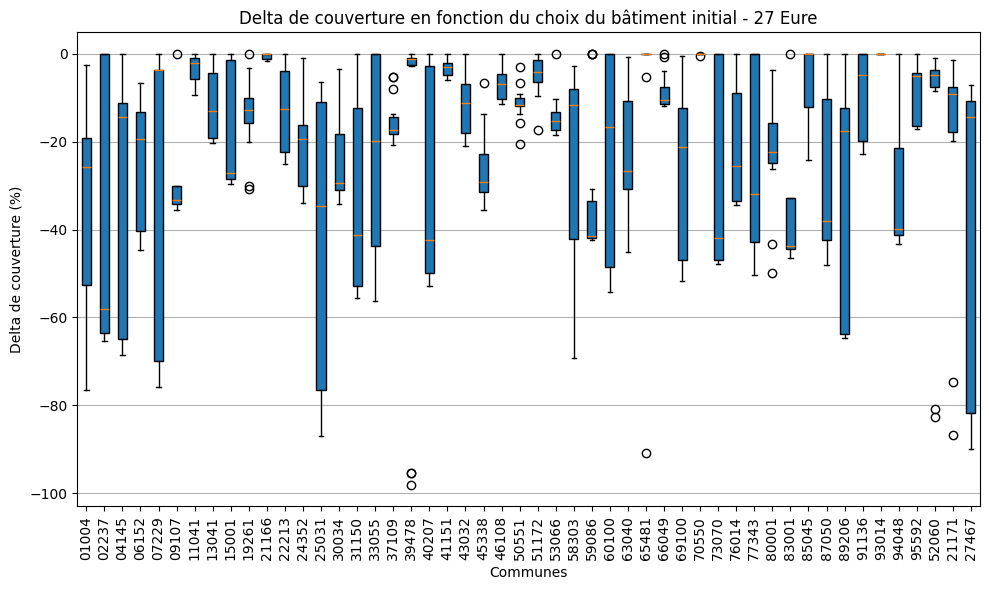

In [163]:
#Boxplot des deltas

plt.figure(figsize=(10, 6))
plt.boxplot(all_communes_deltas.values(), vert=True, patch_artist=True)


plt.xticks(range(1, len(all_communes_deltas) + 1), all_communes_deltas.keys(), rotation=90)
plt.xlabel('Communes')
plt.ylabel('Delta de couverture (%)')
plt.title(f'Delta de couverture en fonction du choix du bâtiment initial - {departement} {nom_departement}')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [170]:
liste_communes_60=["60007", "60010", "60029", "60054","60141","60151","60245","60157","60612","60342", "60057","60342","60581","60590","60356","60636","60644","60291","60238","60213","60212","60200"]

all_communes_coverage_60={'60007': [np.float64(67.59864123334204), np.float64(25.712045989025345), np.float64(74.9934674679906), np.float64(74.9934674679906), np.float64(67.59864123334204), np.float64(67.59864123334204), np.float64(74.9934674679906), np.float64(69.53227070812646), np.float64(67.67703161745493), np.float64(3.214005748628168), np.float64(66.99764828847663), np.float64(3.004964724327149), np.float64(2.9004442121766396), np.float64(2.639142931800366), np.float64(2.639142931800366)], '60010': [np.float64(41.269841269841265), np.float64(6.909430438842204), np.float64(6.3958916900093365), np.float64(5.555555555555555), np.float64(5.182072829131653), np.float64(4.57516339869281), np.float64(4.481792717086835), np.float64(8.169934640522875), np.float64(9.803921568627452), np.float64(3.734827264239029), np.float64(8.169934640522875), np.float64(3.6414565826330536), np.float64(2.987861811391223), np.float64(2.8478057889822597)], '60029': [np.float64(28.83168316831683), np.float64(14.000000000000002), np.float64(8.594059405940593), np.float64(28.83168316831683), np.float64(28.83168316831683), np.float64(27.564356435643568), np.float64(14.000000000000002), np.float64(4.97029702970297), np.float64(18.475247524752476), np.float64(3.4653465346534658), np.float64(3.207920792079208), np.float64(2.5742574257425743), np.float64(23.306930693069308), np.float64(2.099009900990099), np.float64(28.83168316831683)], '60054': [np.float64(36.31624674196351), np.float64(9.730668983492615), np.float64(36.31624674196351), np.float64(7.6455256298870555), np.float64(7.38488271068636), np.float64(36.31624674196351), np.float64(36.31624674196351), np.float64(5.994787141615986), np.float64(5.821025195482189), np.float64(5.734144222415291), np.float64(5.386620330147697), np.float64(5.386620330147697), np.float64(5.386620330147697), np.float64(5.2128583840139004)], '60141': [np.float64(97.65497063254656), np.float64(99.56549269634708), np.float64(97.812179305225), np.float64(99.6091617720911), np.float64(100.0), np.float64(99.81877333566234), np.float64(99.5938775955807), np.float64(98.5480032315116), np.float64(85.08701063341995), np.float64(98.8995392912509), np.float64(98.8995392912509), np.float64(99.08076595558855), np.float64(99.6091617720911), np.float64(99.79038843642874), np.float64(99.81877333566234)], '60151': [np.float64(21.2481426448737), np.float64(10.430906389301635), np.float64(31.53046062407132), np.float64(21.2481426448737), np.float64(31.53046062407132), np.float64(7.578008915304606), np.float64(21.2481426448737), np.float64(8.320950965824665), np.float64(31.53046062407132), np.float64(31.53046062407132), np.float64(31.53046062407132), np.float64(3.3580980683506687), np.float64(10.430906389301635), np.float64(31.53046062407132), np.float64(4.457652303120357)], '60245': [np.float64(92.53355704697987), np.float64(92.53355704697987), np.float64(92.53355704697987), np.float64(92.53355704697987), np.float64(24.916107382550333), np.float64(24.916107382550333), np.float64(21.672259507829978), np.float64(21.672259507829978), np.float64(92.53355704697987), np.float64(92.53355704697987), np.float64(5.508948545861298), np.float64(5.508948545861298), np.float64(88.50671140939598), np.float64(88.50671140939598), np.float64(92.53355704697987)], '60157': [np.float64(98.65381304871751), np.float64(95.02840420037873), np.float64(93.82337751764503), np.float64(94.71165432948872), np.float64(95.88913754518849), np.float64(95.86503701153383), np.float64(97.71044930280598), np.float64(96.2058874160785), np.float64(93.13823377517645), np.float64(95.67567567567568), np.float64(93.58925804785677), np.float64(99.56274746083663), np.float64(97.3317266310897), np.float64(98.18557410914099), np.float64(98.70889998278534)], '60612': [np.float64(57.68903269754768), np.float64(84.04291553133515), np.float64(3.368528610354223), np.float64(84.73433242506812), np.float64(3.010899182561308), np.float64(86.71662125340599), np.float64(1.1682561307901909), np.float64(54.45674386920981), np.float64(67.04019073569482), np.float64(40.53474114441417), np.float64(40.662465940054496), np.float64(3.010899182561308), np.float64(82.65156675749319), np.float64(39.31880108991825), np.float64(1.8307220708446865)], '60342': [np.float64(28.064516129032256), np.float64(19.462365591397848), np.float64(19.462365591397848), np.float64(28.064516129032256), np.float64(28.064516129032256), np.float64(11.774193548387096), np.float64(8.9247311827957), np.float64(19.462365591397848), np.float64(4.704301075268817), np.float64(11.774193548387096), np.float64(28.064516129032256), np.float64(7.903225806451612), np.float64(30.161290322580648), np.float64(9.327956989247312), np.float64(7.903225806451612)], '60057': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0)], '60581': [np.float64(50.327195251864254), np.float64(35.550144574646175), np.float64(22.705828640998327), np.float64(52.14579211687719), np.float64(41.81250951148988), np.float64(51.12616040176533), np.float64(53.933952214274846), np.float64(30.299802161010504), np.float64(38.67752244711611), np.float64(24.874448333586972), np.float64(36.89697154162228), np.float64(34.735961040937454), np.float64(1.5370567645716027), np.float64(24.874448333586972), np.float64(45.83016283670674)], '60590': [np.float64(82.9225004929994), np.float64(73.96963123644251), np.float64(82.25202129757444), np.float64(85.60441727469927), np.float64(86.70873594951686), np.float64(75.2119897456123), np.float64(86.70873594951686), np.float64(2.6621968053638336), np.float64(82.25202129757444), np.float64(2.0114375862748965), np.float64(76.25714849142182), np.float64(85.60441727469927), np.float64(1.7550778939065272), np.float64(85.46637744034707), np.float64(85.46637744034707)], '60356': [np.float64(48.313693620479484), np.float64(48.313693620479484), np.float64(48.313693620479484), np.float64(7.151564404713532), np.float64(6.704591629418935), np.float64(6.50142218610321), np.float64(8.411214953271028), np.float64(48.313693620479484), np.float64(7.273466070702966), np.float64(10.2803738317757), np.float64(7.273466070702966), np.float64(3.2100772043884596), np.float64(8.411214953271028), np.float64(3.169443315725315), np.float64(2.8443722064201546)], '60636': [np.float64(90.47660387186389), np.float64(82.65474433544578), np.float64(83.18430419307231), np.float64(89.26990190120671), np.float64(89.29594582863096), np.float64(91.43154787741992), np.float64(89.60847295772203), np.float64(10.513065370257834), np.float64(4.7834013369216075), np.float64(10.513065370257834), np.float64(91.00616372949041), np.float64(19.49822033162601), np.float64(93.16780970570362), np.float64(80.49309835923258), np.float64(10.790867262783228)], '60644': [np.float64(26.968174204355112), np.float64(9.095477386934673), np.float64(7.788944723618091), np.float64(22.3785594639866), np.float64(22.3785594639866), np.float64(33.266331658291456), np.float64(17.11892797319933), np.float64(26.968174204355112), np.float64(2.88107202680067), np.float64(18.341708542713565), np.float64(18.341708542713565), np.float64(26.968174204355112), np.float64(18.341708542713565), np.float64(5.393634840871022), np.float64(1.8760469011725294)], '60291': [np.float64(33.67208672086721), np.float64(33.67208672086721), np.float64(21.646341463414632), np.float64(21.646341463414632), np.float64(33.67208672086721), np.float64(4.8102981029810294), np.float64(4.471544715447155), np.float64(11.009485094850948), np.float64(21.646341463414632), np.float64(11.009485094850948), np.float64(3.4214092140921406), np.float64(21.646341463414632), np.float64(11.009485094850948), np.float64(2.6084010840108403), np.float64(2.5745257452574526)], '60238': [np.float64(19.815195071868583), np.float64(25.051334702258725), np.float64(26.12936344969199), np.float64(7.340862422997947), np.float64(25.051334702258725), np.float64(4.671457905544147), np.float64(21.303901437371664), np.float64(4.363449691991787), np.float64(21.303901437371664), np.float64(26.12936344969199), np.float64(26.12936344969199), np.float64(25.051334702258725), np.float64(3.8501026694045177), np.float64(25.61601642710472), np.float64(19.815195071868583)], '60213': [np.float64(25.561312607944732), np.float64(9.585492227979273), np.float64(25.561312607944732), np.float64(12.435233160621761), np.float64(16.234887737478413), np.float64(5.4404145077720205), np.float64(20.42314335060449), np.float64(4.058721934369603), np.float64(20.42314335060449), np.float64(4.015544041450777), np.float64(3.842832469775475), np.float64(3.6269430051813467), np.float64(20.42314335060449), np.float64(12.435233160621761), np.float64(3.065630397236615)], '60212': [np.float64(28.668941979522184), np.float64(96.87957094100439), np.float64(96.87957094100439), np.float64(96.87957094100439), np.float64(96.87957094100439), np.float64(7.4110190151145785), np.float64(77.86445636274988), np.float64(74.69527059970747), np.float64(96.87957094100439), np.float64(74.69527059970747), np.float64(74.69527059970747), np.float64(16.040955631399317), np.float64(96.87957094100439), np.float64(19.063871282301317), np.float64(19.01511457825451)], '60200': [np.float64(91.84615384615384), np.float64(100.0), np.float64(8.153846153846153), np.float64(100.0), np.float64(91.84615384615384), np.float64(91.84615384615384), np.float64(100.0), np.float64(100.0), np.float64(91.84615384615384), np.float64(91.84615384615384)]}
all_communes_deltas_60={'60007': [np.float64(-7.394826234648562), np.float64(-49.28142147896526), np.float64(0.0), np.float64(0.0), np.float64(-7.394826234648562), np.float64(-7.394826234648562), np.float64(0.0), np.float64(-5.461196759864137), np.float64(-7.316435850535669), np.float64(-71.77946171936243), np.float64(-7.995819179513973), np.float64(-71.98850274366345), np.float64(-72.09302325581396), np.float64(-72.35432453619023), np.float64(-72.35432453619023)], '60010': [np.float64(0.0), np.float64(-34.36041083099906), np.float64(-34.87394957983193), np.float64(-35.71428571428571), np.float64(-36.08776844070961), np.float64(-36.69467787114846), np.float64(-36.78804855275443), np.float64(-33.09990662931839), np.float64(-31.465919701213814), np.float64(-37.535014005602235), np.float64(-33.09990662931839), np.float64(-37.62838468720821), np.float64(-38.28197945845004), np.float64(-38.42203548085901)], '60029': [np.float64(0.0), np.float64(-14.831683168316827), np.float64(-20.237623762376238), np.float64(0.0), np.float64(0.0), np.float64(-1.2673267326732613), np.float64(-14.831683168316827), np.float64(-23.86138613861386), np.float64(-10.356435643564353), np.float64(-25.366336633663362), np.float64(-25.62376237623762), np.float64(-26.257425742574256), np.float64(-5.524752475247521), np.float64(-26.73267326732673), np.float64(0.0)], '60054': [np.float64(0.0), np.float64(-26.585577758470897), np.float64(0.0), np.float64(-28.670721112076457), np.float64(-28.931364031277152), np.float64(0.0), np.float64(0.0), np.float64(-30.321459600347524), np.float64(-30.49522154648132), np.float64(-30.58210251954822), np.float64(-30.929626411815814), np.float64(-30.929626411815814), np.float64(-30.929626411815814), np.float64(-31.103388357949612)], '60141': [np.float64(-2.345029367453435), np.float64(-0.43450730365292145), np.float64(-2.1878206947749987), np.float64(-0.3908382279089011), np.float64(0.0), np.float64(-0.18122666433765744), np.float64(-0.4061224044193068), np.float64(-1.4519967684883994), np.float64(-14.91298936658005), np.float64(-1.1004607087490967), np.float64(-1.1004607087490967), np.float64(-0.9192340444114535), np.float64(-0.3908382279089011), np.float64(-0.20961156357125788), np.float64(-0.18122666433765744)], '60151': [np.float64(-10.282317979197622), np.float64(-21.099554234769684), np.float64(0.0), np.float64(-10.282317979197622), np.float64(0.0), np.float64(-23.952451708766716), np.float64(-10.282317979197622), np.float64(-23.209509658246656), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-28.172362555720653), np.float64(-21.099554234769684), np.float64(0.0), np.float64(-27.072808320950962)], '60245': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-67.61744966442953), np.float64(-67.61744966442953), np.float64(-70.86129753914989), np.float64(-70.86129753914989), np.float64(0.0), np.float64(0.0), np.float64(-87.02460850111856), np.float64(-87.02460850111856), np.float64(-4.0268456375838895), np.float64(-4.0268456375838895), np.float64(0.0)], '60157': [np.float64(-1.1223962816319357), np.float64(-4.747805129970715), np.float64(-5.952831812704417), np.float64(-5.064555000860722), np.float64(-3.8870717851609555), np.float64(-3.9111723188156162), np.float64(-2.0657600275434618), np.float64(-3.5703219142709486), np.float64(-6.637975555173), np.float64(-4.100533654673768), np.float64(-6.186951282492672), np.float64(-0.21346186951281254), np.float64(-2.4444826992597513), np.float64(-1.5906352212084585), np.float64(-1.0673093475641053)], '60612': [np.float64(-33.860694822888284), np.float64(-7.506811989100811), np.float64(-88.18119891008175), np.float64(-6.8153950953678475), np.float64(-88.53882833787466), np.float64(-4.833106267029976), np.float64(-90.38147138964577), np.float64(-37.092983651226156), np.float64(-24.509536784741144), np.float64(-51.014986376021795), np.float64(-50.88726158038147), np.float64(-88.53882833787466), np.float64(-8.89816076294278), np.float64(-52.23092643051771), np.float64(-89.71900544959128)], '60342': [np.float64(-2.0967741935483915), np.float64(-10.6989247311828), np.float64(-10.6989247311828), np.float64(-2.0967741935483915), np.float64(-2.0967741935483915), np.float64(-18.38709677419355), np.float64(-21.236559139784948), np.float64(-10.6989247311828), np.float64(-25.45698924731183), np.float64(-18.38709677419355), np.float64(-2.0967741935483915), np.float64(-22.258064516129036), np.float64(0.0), np.float64(-20.833333333333336), np.float64(-22.258064516129036)], '60057': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], '60581': [np.float64(-20.171967737026335), np.float64(-34.949018414244414), np.float64(-47.79333434789226), np.float64(-18.3533708720134), np.float64(-28.68665347740071), np.float64(-19.373002587125256), np.float64(-16.565210774615743), np.float64(-40.199360827880085), np.float64(-31.821640541774478), np.float64(-45.62471465530362), np.float64(-33.60219144726831), np.float64(-35.763201947953135), np.float64(-68.96210622431899), np.float64(-45.62471465530362), np.float64(-24.66900015218385)], '60590': [np.float64(-3.78623545651746), np.float64(-12.739104713074354), np.float64(-4.45671465194242), np.float64(-1.1043186748175913), np.float64(0.0), np.float64(-11.496746203904564), np.float64(0.0), np.float64(-84.04653914415303), np.float64(-4.45671465194242), np.float64(-84.69729836324197), np.float64(-10.451587458095048), np.float64(-1.1043186748175913), np.float64(-84.95365805561033), np.float64(-1.2423585091697902), np.float64(-1.2423585091697902)], '60356': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-41.16212921576595), np.float64(-41.60910199106055), np.float64(-41.81227143437627), np.float64(-39.902478667208456), np.float64(0.0), np.float64(-41.04022754977652), np.float64(-38.033319788703785), np.float64(-41.04022754977652), np.float64(-45.10361641609102), np.float64(-39.902478667208456), np.float64(-45.144250304754166), np.float64(-45.46932141405933)], '60636': [np.float64(-2.6912058338397316), np.float64(-10.513065370257834), np.float64(-9.98350551263131), np.float64(-3.89790780449691), np.float64(-3.8718638770726557), np.float64(-1.736261828283702), np.float64(-3.5593367479815896), np.float64(-82.65474433544578), np.float64(-88.384408368782), np.float64(-82.65474433544578), np.float64(-2.161645976213208), np.float64(-73.66958937407762), np.float64(0.0), np.float64(-12.674711346471042), np.float64(-82.3769424429204)], '60644': [np.float64(-6.298157453936344), np.float64(-24.17085427135678), np.float64(-25.477386934673365), np.float64(-10.887772194304855), np.float64(-10.887772194304855), np.float64(0.0), np.float64(-16.147403685092126), np.float64(-6.298157453936344), np.float64(-30.385259631490786), np.float64(-14.92462311557789), np.float64(-14.92462311557789), np.float64(-6.298157453936344), np.float64(-14.92462311557789), np.float64(-27.872696817420433), np.float64(-31.390284757118927)], '60291': [np.float64(0.0), np.float64(0.0), np.float64(-12.02574525745258), np.float64(-12.02574525745258), np.float64(0.0), np.float64(-28.861788617886184), np.float64(-29.200542005420058), np.float64(-22.662601626016265), np.float64(-12.02574525745258), np.float64(-22.662601626016265), np.float64(-30.250677506775073), np.float64(-12.02574525745258), np.float64(-22.662601626016265), np.float64(-31.063685636856373), np.float64(-31.09756097560976)], '60238': [np.float64(-6.314168377823407), np.float64(-1.0780287474332653), np.float64(0.0), np.float64(-18.788501026694043), np.float64(-1.0780287474332653), np.float64(-21.45790554414784), np.float64(-4.825462012320326), np.float64(-21.765913757700204), np.float64(-4.825462012320326), np.float64(0.0), np.float64(0.0), np.float64(-1.0780287474332653), np.float64(-22.279260780287473), np.float64(-0.5133470225872685), np.float64(-6.314168377823407)], '60213': [np.float64(0.0), np.float64(-15.975820379965459), np.float64(0.0), np.float64(-13.12607944732297), np.float64(-9.326424870466319), np.float64(-20.12089810017271), np.float64(-5.138169257340241), np.float64(-21.502590673575128), np.float64(-5.138169257340241), np.float64(-21.545768566493955), np.float64(-21.718480138169255), np.float64(-21.934369602763386), np.float64(-5.138169257340241), np.float64(-13.12607944732297), np.float64(-22.495682210708118)], '60212': [np.float64(-68.2106289614822), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-89.46855192588981), np.float64(-19.01511457825451), np.float64(-22.184300341296918), np.float64(0.0), np.float64(-22.184300341296918), np.float64(-22.184300341296918), np.float64(-80.83861530960507), np.float64(0.0), np.float64(-77.81569965870307), np.float64(-77.86445636274988)], '60200': [np.float64(-8.15384615384616), np.float64(0.0), np.float64(-91.84615384615384), np.float64(0.0), np.float64(-8.15384615384616), np.float64(-8.15384615384616), np.float64(0.0), np.float64(0.0), np.float64(-8.15384615384616), np.float64(-8.15384615384616)]}
all_communes_ratio_solution_60={'60007': [np.float64(0.9013937282229963), np.float64(0.3428571428571428), np.float64(1.0), np.float64(1.0), np.float64(0.9013937282229963), np.float64(0.9013937282229963), np.float64(1.0), np.float64(0.9271777003484318), np.float64(0.9024390243902439), np.float64(0.04285714285714285), np.float64(0.8933797909407667), np.float64(0.04006968641114982), np.float64(0.03867595818815331), np.float64(0.03519163763066202), np.float64(0.03519163763066202)], '60010': [np.float64(1.0), np.float64(0.16742081447963802), np.float64(0.15497737556561086), np.float64(0.13461538461538464), np.float64(0.12556561085972853), np.float64(0.11085972850678734), np.float64(0.10859728506787332), np.float64(0.1979638009049774), np.float64(0.2375565610859729), np.float64(0.0904977375565611), np.float64(0.1979638009049774), np.float64(0.08823529411764708), np.float64(0.07239819004524888), np.float64(0.06900452488687783)], '60029': [np.float64(1.0), np.float64(0.4855769230769232), np.float64(0.2980769230769231), np.float64(1.0), np.float64(1.0), np.float64(0.9560439560439562), np.float64(0.4855769230769232), np.float64(0.17239010989010992), np.float64(0.6407967032967034), np.float64(0.12019230769230772), np.float64(0.11126373626373628), np.float64(0.0892857142857143), np.float64(0.808379120879121), np.float64(0.07280219780219781), np.float64(1.0)], '60054': [np.float64(1.0), np.float64(0.2679425837320574), np.float64(1.0), np.float64(0.2105263157894737), np.float64(0.20334928229665072), np.float64(1.0), np.float64(1.0), np.float64(0.16507177033492823), np.float64(0.16028708133971292), np.float64(0.15789473684210525), np.float64(0.14832535885167464), np.float64(0.14832535885167464), np.float64(0.14832535885167464), np.float64(0.1435406698564593)], '60141': [np.float64(0.9765497063254657), np.float64(0.9956549269634708), np.float64(0.97812179305225), np.float64(0.996091617720911), np.float64(1.0), np.float64(0.9981877333566235), np.float64(0.9959387759558069), np.float64(0.985480032315116), np.float64(0.8508701063341995), np.float64(0.988995392912509), np.float64(0.988995392912509), np.float64(0.9908076595558855), np.float64(0.996091617720911), np.float64(0.9979038843642875), np.float64(0.9981877333566235)], '60151': [np.float64(0.6738925541941565), np.float64(0.33081998114985867), np.float64(1.0), np.float64(0.6738925541941565), np.float64(1.0), np.float64(0.2403393025447691), np.float64(0.6738925541941565), np.float64(0.2639019792648445), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.10650329877474082), np.float64(0.33081998114985867), np.float64(1.0), np.float64(0.1413760603204524)], '60245': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.2692656391659111), np.float64(0.2692656391659111), np.float64(0.23420973103656695), np.float64(0.23420973103656695), np.float64(1.0), np.float64(1.0), np.float64(0.0595346025989725), np.float64(0.0595346025989725), np.float64(0.9564823209428831), np.float64(0.9564823209428831), np.float64(1.0)], '60157': [np.float64(0.9887508626639063), np.float64(0.9524154589371983), np.float64(0.9403381642512078), np.float64(0.949240855762595), np.float64(0.9610420979986197), np.float64(0.9608005521049001), np.float64(0.979296066252588), np.float64(0.964216701173223), np.float64(0.9334713595583162), np.float64(0.9589026915113873), np.float64(0.9379917184265012), np.float64(0.9978605935127676), np.float64(0.9755003450655626), np.float64(0.9840579710144929), np.float64(0.9893029675638373)], '60612': [np.float64(0.6301387700435284), np.float64(0.9180029018936717), np.float64(0.0367945236057889), np.float64(0.9255552661929387), np.float64(0.03288812827858179), np.float64(0.9472078574351724), np.float64(0.012760891402209906), np.float64(0.5948323970385804), np.float64(0.7322817069087392), np.float64(0.44276200751516054), np.float64(0.4441571487034488), np.float64(0.03288812827858179), np.float64(0.9028051638825849), np.float64(0.4294802634026563), np.float64(0.019997023698798317)], '60342': [np.float64(0.9304812834224597), np.float64(0.6452762923351157), np.float64(0.6452762923351157), np.float64(0.9304812834224597), np.float64(0.9304812834224597), np.float64(0.3903743315508021), np.float64(0.29590017825311943), np.float64(0.6452762923351157), np.float64(0.15597147950089124), np.float64(0.3903743315508021), np.float64(0.9304812834224597), np.float64(0.26203208556149726), np.float64(1.0), np.float64(0.3092691622103387), np.float64(0.26203208556149726)], '60057': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)], '60581': [np.float64(0.7138694009713976), np.float64(0.5042633567188343), np.float64(0.32207231516459794), np.float64(0.7396654074473825), np.float64(0.5930922827846734), np.float64(0.7252023745277927), np.float64(0.7650296815974096), np.float64(0.42978953049109553), np.float64(0.548623853211009), np.float64(0.3528332433890987), np.float64(0.5233675121424716), np.float64(0.4927145169994603), np.float64(0.021802482460874257), np.float64(0.3528332433890987), np.float64(0.650080949811117)], '60590': [np.float64(0.9563338639981805), np.float64(0.8530816465772116), np.float64(0.9486013190811917), np.float64(0.987264043666136), np.float64(1.0), np.float64(0.8674095974528087), np.float64(1.0), np.float64(0.030702751876279282), np.float64(0.9486013190811917), np.float64(0.02319763475096657), np.float64(0.8794632704116443), np.float64(0.987264043666136), np.float64(0.02024107345917671), np.float64(0.985672049124403), np.float64(0.985672049124403)], '60356': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.14802354920100924), np.float64(0.13877207737594616), np.float64(0.1345668629100084), np.float64(0.17409587888982336), np.float64(1.0), np.float64(0.15054667788057188), np.float64(0.21278385197645075), np.float64(0.15054667788057188), np.float64(0.06644238856181664), np.float64(0.17409587888982336), np.float64(0.0656013456686291), np.float64(0.05887300252312868)], '60636': [np.float64(0.9711144241520687), np.float64(0.8871598956392098), np.float64(0.8928438315318672), np.float64(0.9581625046589639), np.float64(0.9584420424897504), np.float64(0.9813641446142378), np.float64(0.9617964964591875), np.float64(0.11284010436079016), np.float64(0.05134178158777488), np.float64(0.11284010436079016), np.float64(0.9767983600447261), np.float64(0.20928065598210957), np.float64(1.0), np.float64(0.8639582556839359), np.float64(0.11582184122251213)], '60644': [np.float64(0.8106747230614302), np.float64(0.27341389728096677), np.float64(0.2341389728096677), np.float64(0.6727089627391742), np.float64(0.6727089627391742), np.float64(1.0), np.float64(0.5146022155085599), np.float64(0.8106747230614302), np.float64(0.0866062437059416), np.float64(0.5513595166163141), np.float64(0.5513595166163141), np.float64(0.8106747230614302), np.float64(0.5513595166163141), np.float64(0.16213494461228603), np.float64(0.056394763343403834)], '60291': [np.float64(1.0), np.float64(1.0), np.float64(0.6428571428571427), np.float64(0.6428571428571427), np.float64(1.0), np.float64(0.14285714285714282), np.float64(0.1327967806841046), np.float64(0.3269617706237424), np.float64(0.6428571428571427), np.float64(0.3269617706237424), np.float64(0.10160965794768609), np.float64(0.6428571428571427), np.float64(0.3269617706237424), np.float64(0.07746478873239436), np.float64(0.07645875251509053)], '60238': [np.float64(0.7583497053045187), np.float64(0.9587426326129665), np.float64(1.0), np.float64(0.2809430255402751), np.float64(0.9587426326129665), np.float64(0.1787819253438114), np.float64(0.8153241650294696), np.float64(0.1669941060903733), np.float64(0.8153241650294696), np.float64(1.0), np.float64(1.0), np.float64(0.9587426326129665), np.float64(0.14734774066797646), np.float64(0.9803536345776032), np.float64(0.7583497053045187)], '60213': [np.float64(1.0), np.float64(0.37499999999999994), np.float64(1.0), np.float64(0.48648648648648646), np.float64(0.6351351351351352), np.float64(0.21283783783783783), np.float64(0.7989864864864865), np.float64(0.1587837837837838), np.float64(0.7989864864864865), np.float64(0.1570945945945946), np.float64(0.15033783783783783), np.float64(0.14189189189189189), np.float64(0.7989864864864865), np.float64(0.48648648648648646), np.float64(0.11993243243243243)], '60212': [np.float64(0.29592350276799195), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.07649723200805235), np.float64(0.8037242073477604), np.float64(0.771011575239054), np.float64(1.0), np.float64(0.771011575239054), np.float64(0.771011575239054), np.float64(0.16557624559637643), np.float64(1.0), np.float64(0.19677906391545044), np.float64(0.19627579265223957)], '60200': [np.float64(0.9184615384615384), np.float64(1.0), np.float64(0.08153846153846153), np.float64(1.0), np.float64(0.9184615384615384), np.float64(0.9184615384615384), np.float64(1.0), np.float64(1.0), np.float64(0.9184615384615384), np.float64(0.9184615384615384)]}

In [171]:
liste_communes_01=["01004","01007","01025","01014","01060","01072","01043","01079","01130","01354","01313","01163","01232","01247","01305","01420","01254","01275","01304","01419", "01443", "01451"]

all_communes_ratio_solution_01={'01004': [np.float64(0.7431661644425313), np.float64(0.46136461472234186), np.float64(0.16939302625914768), np.float64(0.2734341368919501), np.float64(0.7822589324149808), np.float64(0.7827163151097718), np.float64(0.4609879466207491), np.float64(0.7539819199311237), np.float64(0.07689410245372363), np.float64(0.824741713301765), np.float64(0.9681715454154112), np.float64(0.45859341368919504), np.float64(0.7405563925957814), np.float64(0.17474709427464485), np.float64(0.6901366767111494)], '01007': [np.float64(1.0), np.float64(0.5027726432532348), np.float64(0.8391866913123845), np.float64(0.39186691312384464), np.float64(0.4158964879852125), np.float64(0.9944547134935303), np.float64(0.210720887245841), np.float64(0.20702402957486135), np.float64(0.6709796672828096), np.float64(0.18114602587800369), np.float64(0.29390018484288355), np.float64(0.17375231053604437), np.float64(0.6709796672828096), np.float64(0.16820702402957485), np.float64(0.6709796672828096)], '01025': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.10929951690821257), np.float64(0.10929951690821257), np.float64(0.10265700483091789), np.float64(0.10265700483091789), np.float64(0.13949275362318841), np.float64(0.13949275362318841), np.float64(0.08272946859903382), np.float64(0.08272946859903382), np.float64(1.0)], '01014': [np.float64(1.0), np.float64(0.6715063520871143), np.float64(0.109411459683692), np.float64(0.46227638060668913), np.float64(0.1078558465128338), np.float64(0.2398236971739694), np.float64(1.0), np.float64(0.7101374124967591), np.float64(1.0), np.float64(0.4347938812548613), np.float64(0.4347938812548613), np.float64(1.0), np.float64(0.06092818252527871), np.float64(0.20352605652061187), np.float64(0.05677988073632357)], '01060': [np.float64(0.29775280898876416), np.float64(0.7134831460674158), np.float64(1.0), np.float64(0.16573033707865173), np.float64(0.15870786516853935), np.float64(0.7134831460674158), np.float64(0.7134831460674158), np.float64(0.7134831460674158), np.float64(0.2457865168539326), np.float64(0.12780898876404495), np.float64(0.43960674157303375), np.float64(0.12219101123595506), np.float64(0.12078651685393259), np.float64(0.43960674157303375), np.float64(1.0)], '01072': [np.float64(0.6201146430432517), np.float64(0.3256904637832204), np.float64(0.22980719124544033), np.float64(0.6503387180823346), np.float64(1.0), np.float64(0.7196456487754038), np.float64(0.2621156852527358), np.float64(0.09484106305367379), np.float64(0.2621156852527358), np.float64(0.3256904637832204), np.float64(0.2089630015633142), np.float64(0.068264721208963), np.float64(0.10891089108910892), np.float64(0.11047420531526836), np.float64(0.713392391870766)], '01043': [np.float64(0.8545299872394727), np.float64(0.8545299872394727), np.float64(0.8926414291790729), np.float64(0.06865163760102085), np.float64(0.3101658868566568), np.float64(0.07222458528285836), np.float64(0.9557635048915356), np.float64(0.43581454700127603), np.float64(0.27775414717141644), np.float64(0.7264993619736284), np.float64(0.8491705657167163), np.float64(0.8586984262016163), np.float64(0.07222458528285836), np.float64(0.9270948532539346), np.float64(0.15959166312207573)], '01079': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9657836644591612), np.float64(0.8940397350993379), np.float64(0.10596026490066224), np.float64(0.057947019867549666), np.float64(0.04690949227373068), np.float64(0.10596026490066224), np.float64(0.04470198675496689), np.float64(0.04304635761589404), np.float64(0.040838852097130236), np.float64(1.0), np.float64(0.0402869757174393), np.float64(0.8940397350993379)], '01130': [np.float64(0.780045351473923), np.float64(0.780045351473923), np.float64(0.5328798185941043), np.float64(0.5328798185941043), np.float64(0.4512471655328798), np.float64(0.4512471655328798), np.float64(0.7414965986394558), np.float64(0.7414965986394558), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.2154195011337868), np.float64(0.2154195011337868), np.float64(0.36734693877551017)], '01354': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9906574558560837), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9829747545803759), np.float64(0.9923172987242921)], '01313': [np.float64(0.1470900720103884), np.float64(0.09538425215440917), np.float64(0.48459449887852674), np.float64(0.7295478692008028), np.float64(0.04025498760476921), np.float64(0.1470900720103884), np.float64(0.1643253452957148), np.float64(0.1391807342698619), np.float64(0.7120764962814309), np.float64(0.38366190532404676), np.float64(0.3050407271868729), np.float64(0.9996458505489317), np.float64(1.0), np.float64(0.327352142604179), np.float64(0.049817022783614696)], '01163': [np.float64(0.4613953488372092), np.float64(0.1497674418604651), np.float64(0.961860465116279), np.float64(0.961860465116279), np.float64(0.12744186046511627), np.float64(0.1237209302325581), np.float64(1.0), np.float64(0.4613953488372092), np.float64(0.09953488372093021), np.float64(0.09953488372093021), np.float64(0.09674418604651161), np.float64(0.09581395348837209), np.float64(0.09488372093023253), np.float64(0.961860465116279), np.float64(0.08930232558139534)], '01232': [np.float64(1.0), np.float64(0.4623655913978494), np.float64(0.4229390681003585), np.float64(0.40860215053763443), np.float64(1.0), np.float64(0.39784946236559143), np.float64(0.36200716845878134), np.float64(0.34767025089605735), np.float64(0.34408602150537637), np.float64(0.32616487455197135), np.float64(0.3225806451612903), np.float64(0.5304659498207885), np.float64(0.3118279569892473), np.float64(0.2939068100358423), np.float64(0.29032258064516125)], '01247': [np.float64(1.0), np.float64(0.43058823529411755), np.float64(1.0), np.float64(0.39764705882352935), np.float64(0.7505882352941177), np.float64(0.32705882352941174), np.float64(1.0), np.float64(0.20588235294117646), np.float64(0.5494117647058823), np.float64(0.39764705882352935), np.float64(0.10588235294117646), np.float64(0.7376470588235293), np.float64(0.7223529411764706), np.float64(0.728235294117647), np.float64(0.08705882352941176)], '01305': [np.float64(0.9828669331810396), np.float64(0.9438892061679041), np.float64(0.9688749286122216), np.float64(0.7430039977155911), np.float64(0.8913478012564249), np.float64(0.7013135351227869), np.float64(0.7223015419760137), np.float64(0.9772986864648772), np.float64(0.9554540262707024), np.float64(0.8243860651056538), np.float64(0.8243860651056538), np.float64(0.9438892061679041), np.float64(0.7505711022272988), np.float64(0.470445459737293), np.float64(0.8183894917190178)], '01420': [np.float64(0.9847145488029466), np.float64(0.9847145488029466), np.float64(1.0), np.float64(1.0), np.float64(0.9847145488029466), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9847145488029466)], '01254': [np.float64(1.0), np.float64(0.44534412955465585), np.float64(0.3724696356275303), np.float64(0.32388663967611336), np.float64(0.3016194331983806), np.float64(0.2935222672064778), np.float64(0.45951417004048584), np.float64(0.2388663967611336), np.float64(0.45951417004048584), np.float64(0.17611336032388664), np.float64(0.14170040485829957), np.float64(0.13562753036437247), np.float64(0.13157894736842107), np.float64(0.12753036437246965), np.float64(0.12753036437246965)], '01275': [np.float64(1.0), np.float64(1.0), np.float64(0.7142857142857143), np.float64(0.4138438880706923), np.float64(0.2076583210603829), np.float64(0.45949926362297494), np.float64(0.4138438880706923), np.float64(0.4609720176730487), np.float64(0.30191458026509577), np.float64(0.16053019145802652), np.float64(0.31222385861561125), np.float64(0.31222385861561125), np.float64(0.1531664212076583), np.float64(1.0), np.float64(0.13991163475699558)], '01304': [np.float64(0.8838709677419354), np.float64(0.38617511520737324), np.float64(0.2571428571428571), np.float64(0.8838709677419354), np.float64(0.44976958525345617), np.float64(0.3723502304147465), np.float64(0.3723502304147465), np.float64(0.5244239631336405), np.float64(0.16774193548387095), np.float64(0.44976958525345617), np.float64(0.19539170506912443), np.float64(1.0), np.float64(1.0), np.float64(0.09032258064516129), np.float64(0.08755760368663594)], '01419': [np.float64(0.7243768302264124), np.float64(0.7243768302264124), np.float64(1.0), np.float64(0.34733233340475683), np.float64(0.34733233340475683), np.float64(0.3821869866438112), np.float64(0.03399757160202843), np.float64(0.9766445253910436), np.float64(0.989715020355689), np.float64(0.9806442396971646), np.float64(0.9766445253910436), np.float64(0.9789300764231127), np.float64(0.9380044282551246), np.float64(0.989715020355689), np.float64(0.989715020355689)], '01443': [np.float64(0.2226890756302521), np.float64(0.13895558223289314), np.float64(0.40531212484993995), np.float64(0.9561824729891957), np.float64(0.8154261704681873), np.float64(0.13895558223289314), np.float64(0.16551620648259305), np.float64(0.033013205282112844), np.float64(0.967737094837935), np.float64(0.6092436974789915), np.float64(0.7165366146458583), np.float64(0.8031212484993998), np.float64(0.02656062424969988), np.float64(0.781812725090036), np.float64(0.9443277310924368)], '01451': [np.float64(0.884240070493783), np.float64(0.8873404914983194), np.float64(0.8867856793185601), np.float64(0.8819555497535981), np.float64(0.8819555497535981), np.float64(0.8799647531085801), np.float64(1.0), np.float64(0.9081622662445743), np.float64(0.867399889037564), np.float64(0.8805195652883392), np.float64(0.9954309585196306), np.float64(0.884240070493783), np.float64(0.8563362814529553), np.float64(0.9951372344244641), np.float64(0.884240070493783)]}
all_communes_deltas_01={'01004': [np.float64(-21.271475366000395), np.float64(-44.610825144283254), np.float64(-68.79247721550013), np.float64(-60.17559106000846), np.float64(-18.033736657976235), np.float64(-17.995855337923658), np.float64(-44.64202152550303), np.float64(-20.37569356240389), np.float64(-76.45341711790003), np.float64(-14.515230518974079), np.float64(-2.6360942130712743), np.float64(-44.840341377543055), np.float64(-21.487621721594564), np.float64(-68.34904293959043), np.float64(-25.663480179156352)], '01007': [np.float64(0.0), np.float64(-8.770785784153897), np.float64(-2.836648190414085), np.float64(-10.7270948809912), np.float64(-10.303227910009785), np.float64(-0.09781545484186793), np.float64(-13.922399739158788), np.float64(-13.987610042386699), np.float64(-5.803716987283993), np.float64(-14.444082164982069), np.float64(-12.455167916530813), np.float64(-14.574502771437889), np.float64(-5.803716987283993), np.float64(-14.672318226279753), np.float64(-5.803716987283993)], '01025': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-38.252074688796675), np.float64(-38.252074688796675), np.float64(-38.537344398340245), np.float64(-38.537344398340245), np.float64(-36.95539419087137), np.float64(-36.95539419087137), np.float64(-39.39315352697095), np.float64(-39.39315352697095), np.float64(0.0)], '01014': [np.float64(0.0), np.float64(-10.603397773872292), np.float64(-28.747175495857395), np.float64(-17.35710101263704), np.float64(-28.797388902837056), np.float64(-24.53761821072893), np.float64(0.0), np.float64(-9.35643150054398), np.float64(0.0), np.float64(-18.24420453594443), np.float64(-18.24420453594443), np.float64(0.0), np.float64(-30.31216001339024), np.float64(-25.70926437358775), np.float64(-30.446062432002677)], '01060': [np.float64(-22.655188038060707), np.float64(-9.243316719528767), np.float64(0.0), np.float64(-26.914363389216124), np.float64(-27.140915269596732), np.float64(-9.243316719528767), np.float64(-9.243316719528767), np.float64(-9.243316719528767), np.float64(-24.331671952877205), np.float64(-28.137743543271405), np.float64(-18.07884005437245), np.float64(-28.31898504757589), np.float64(-28.36429542365201), np.float64(-18.07884005437245), np.float64(0.0)], '01072': [np.float64(-12.527925760439938), np.float64(-22.237497851864582), np.float64(-25.39955318783296), np.float64(-11.53119092627599), np.float64(0.0), np.float64(-9.245574841037978), np.float64(-24.334078020278398), np.float64(-29.850489774875406), np.float64(-24.334078020278398), np.float64(-22.237497851864582), np.float64(-26.08695652173913), np.float64(-30.726929025605774), np.float64(-29.38649252448874), np.float64(-29.334937274445778), np.float64(-9.45179584120983)], '01043': [np.float64(-11.645328248433657), np.float64(-11.645328248433657), np.float64(-8.59438845001361), np.float64(-74.55734132388994), np.float64(-55.2233723780986), np.float64(-74.27131571778807), np.float64(-3.54126940888041), np.float64(-45.16480523018251), np.float64(-57.818033233451374), np.float64(-21.89457913375101), np.float64(-12.07436665758648), np.float64(-11.311631707981476), np.float64(-74.27131571778807), np.float64(-5.836284391174061), np.float64(-67.27730863524924)], '01079': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-2.034120734908136), np.float64(-6.299212598425193), np.float64(-53.14960629921261), np.float64(-56.00393700787402), np.float64(-56.66010498687665), np.float64(-53.14960629921261), np.float64(-56.79133858267717), np.float64(-56.88976377952756), np.float64(-57.020997375328086), np.float64(0.0), np.float64(-57.05380577427822), np.float64(-6.299212598425193)], '01130': [np.float64(-4.349775784753362), np.float64(-4.349775784753362), np.float64(-9.237668161434978), np.float64(-9.237668161434978), np.float64(-10.852017937219731), np.float64(-10.852017937219731), np.float64(-5.112107623318385), np.float64(-5.112107623318385), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-15.515695067264575), np.float64(-15.515695067264575), np.float64(-12.511210762331839)], '01354': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.9342544143916314), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.7025245419624184), np.float64(-0.768270127570787)], '01313': [np.float64(-35.40104855700916), np.float64(-37.54716056641677), np.float64(-21.392522906560828), np.float64(-11.225439756969958), np.float64(-39.83536674996325), np.float64(-35.40104855700916), np.float64(-34.68567788720662), np.float64(-35.72933509726101), np.float64(-11.950610024988968), np.float64(-25.581851144103087), np.float64(-28.845117350188637), np.float64(-0.014699397324704933), np.float64(0.0), np.float64(-27.919055318731928), np.float64(-39.43848302219608)], '01163': [np.float64(-16.08780216726869), np.float64(-25.395943317588223), np.float64(-1.1392053348152302), np.float64(-1.1392053348152302), np.float64(-26.062795220894696), np.float64(-26.17393720477911), np.float64(0.0), np.float64(-16.08780216726869), np.float64(-26.896360100027792), np.float64(-26.896360100027792), np.float64(-26.9797165879411), np.float64(-27.0075020839122), np.float64(-27.035287579883306), np.float64(-1.1392053348152302), np.float64(-27.202000555709922)], '01232': [np.float64(0.0), np.float64(-5.543237250554324), np.float64(-5.949741315594974), np.float64(-6.097560975609756), np.float64(0.0), np.float64(-6.208425720620842), np.float64(-6.577974870657798), np.float64(-6.72579453067258), np.float64(-6.762749445676275), np.float64(-6.947524020694752), np.float64(-6.984478935698448), np.float64(-4.841093865484109), np.float64(-7.095343680709535), np.float64(-7.280118255728012), np.float64(-7.317073170731708)], '01247': [np.float64(0.0), np.float64(-13.683912920554144), np.float64(0.0), np.float64(-14.475544246536614), np.float64(-5.993780039581566), np.float64(-16.171897087927626), np.float64(0.0), np.float64(-19.083969465648856), np.float64(-10.828385637545946), np.float64(-14.475544246536614), np.float64(-21.487135990952787), np.float64(-6.304778060503253), np.float64(-6.67232117613797), np.float64(-6.530958439355388), np.float64(-21.939496748657056)], '01305': [np.float64(-1.588983050847446), np.float64(-5.203919491525426), np.float64(-2.886652542372886), np.float64(-23.83474576271186), np.float64(-10.076800847457633), np.float64(-27.701271186440678), np.float64(-25.75476694915254), np.float64(-2.105402542372886), np.float64(-4.131355932203391), np.float64(-16.28707627118645), np.float64(-16.28707627118645), np.float64(-5.203919491525426), np.float64(-23.132944915254228), np.float64(-49.112817796610166), np.float64(-16.843220338983045)], '01420': [np.float64(-1.4903932483390179), np.float64(-1.4903932483390179), np.float64(0.0), np.float64(0.0), np.float64(-1.4903932483390179), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.4903932483390179)], '01254': [np.float64(0.0), np.float64(-12.620912022109627), np.float64(-14.279134039613082), np.float64(-15.384615384615383), np.float64(-15.891294334408105), np.float64(-16.07554122524182), np.float64(-12.298479963150621), np.float64(-17.319207738369414), np.float64(-12.298479963150621), np.float64(-18.747121142330723), np.float64(-19.53017042837402), np.float64(-19.668355596499307), np.float64(-19.760479041916167), np.float64(-19.852602487333026), np.float64(-19.852602487333026)], '01275': [np.float64(0.0), np.float64(0.0), np.float64(-6.272227610733916), np.float64(-12.867765923052051), np.float64(-17.39411574523117), np.float64(-11.865502748140964), np.float64(-12.867765923052051), np.float64(-11.83317167798254), np.float64(-15.324927255092142), np.float64(-18.42870999030068), np.float64(-15.098609763983188), np.float64(-15.098609763983188), np.float64(-18.59036534109279), np.float64(0.0), np.float64(-18.88134497251859)], '01304': [np.float64(-2.5641025641025657), np.float64(-13.553113553113555), np.float64(-16.402116402116402), np.float64(-2.5641025641025657), np.float64(-12.14896214896215), np.float64(-13.858363858363859), np.float64(-13.858363858363859), np.float64(-10.500610500610502), np.float64(-18.37606837606838), np.float64(-12.14896214896215), np.float64(-17.765567765567766), np.float64(0.0), np.float64(0.0), np.float64(-20.085470085470085), np.float64(-20.146520146520146)], '01419': [np.float64(-23.221807678420987), np.float64(-23.221807678420987), np.float64(0.0), np.float64(-54.98856661451438), np.float64(-54.98856661451438), np.float64(-52.05199181610302), np.float64(-81.38765194367554), np.float64(-1.9677458177879288), np.float64(-0.86653026838367), np.float64(-1.6307618245276103), np.float64(-1.9677458177879288), np.float64(-1.7751835359248958), np.float64(-5.223251895534958), np.float64(-0.86653026838367), np.float64(-0.86653026838367)], '01443': [np.float64(-48.92330940687572), np.float64(-54.193426520589355), np.float64(-37.42916509255762), np.float64(-2.7578390630902945), np.float64(-11.616924820551567), np.float64(-54.193426520589355), np.float64(-52.521722704949), np.float64(-60.86135247449944), np.float64(-2.0306006800151195), np.float64(-24.593879863996982), np.float64(-17.840952021156035), np.float64(-12.391386475255004), np.float64(-61.26747261050246), np.float64(-13.732527389497548), np.float64(-3.50396675481678)], '01451': [np.float64(-11.016896508883079), np.float64(-10.721828798608513), np.float64(-10.774630388868175), np.float64(-11.234314821716978), np.float64(-11.234314821716978), np.float64(-11.42377935147222), np.float64(0.0), np.float64(-8.74021617592247), np.float64(-12.619580072058639), np.float64(-11.370977761212572), np.float64(-0.4348366256677849), np.float64(-11.016896508883079), np.float64(-13.6725059013542), np.float64(-0.4627904087464145), np.float64(-11.016896508883079)]}
all_communes_coverage_01={'01004': [np.float64(61.55046014662299), np.float64(38.21111036834013), np.float64(14.029458297123249), np.float64(22.646344452614926), np.float64(64.78819885464715), np.float64(64.82608017469973), np.float64(38.17991398712035), np.float64(62.446241950219495), np.float64(6.368518394723354), np.float64(68.3067049936493), np.float64(80.18584129955211), np.float64(37.98159413508033), np.float64(61.33431379102882), np.float64(14.472892573032956), np.float64(57.15845533346703)], '01007': [np.float64(17.63938702314966), np.float64(8.868601238995762), np.float64(14.802738832735574), np.float64(6.91229214215846), np.float64(7.336159113139876), np.float64(17.54157156830779), np.float64(3.7169872839908704), np.float64(3.6517769807629605), np.float64(11.835670035865666), np.float64(3.1953048581675905), np.float64(5.184219106618846), np.float64(3.0648842517117707), np.float64(11.835670035865666), np.float64(2.9670687968699054), np.float64(11.835670035865666)], '01025': [np.float64(42.946058091286304), np.float64(42.946058091286304), np.float64(42.946058091286304), np.float64(42.946058091286304), np.float64(42.946058091286304), np.float64(42.946058091286304), np.float64(4.693983402489627), np.float64(4.693983402489627), np.float64(4.408713692946058), np.float64(4.408713692946058), np.float64(5.990663900414938), np.float64(5.990663900414938), np.float64(3.5529045643153525), np.float64(3.5529045643153525), np.float64(42.946058091286304)], '01014': [np.float64(32.2788517867604), np.float64(21.675454012888107), np.float64(3.531676290903005), np.float64(14.921750774123357), np.float64(3.4814628839233404), np.float64(7.741233576031467), np.float64(32.2788517867604), np.float64(22.92242028621642), np.float64(32.2788517867604), np.float64(14.034647250815969), np.float64(14.034647250815969), np.float64(32.2788517867604), np.float64(1.9666917733701563), np.float64(6.56958741317265), np.float64(1.8327893547577203)], '01060': [np.float64(9.605799728137745), np.float64(23.017671046669687), np.float64(32.260987766198454), np.float64(5.346624376982329), np.float64(5.120072496601722), np.float64(23.017671046669687), np.float64(23.017671046669687), np.float64(23.017671046669687), np.float64(7.92931581332125), np.float64(4.12324422292705), np.float64(14.182147711826007), np.float64(3.942002718622564), np.float64(3.8966923425464426), np.float64(14.182147711826007), np.float64(32.260987766198454)], '01072': [np.float64(20.45024918370854), np.float64(10.740677092283898), np.float64(7.578621756315518), np.float64(21.446984017872488), np.float64(32.97817494414848), np.float64(23.7326001031105), np.float64(8.64409692387008), np.float64(3.1276851692730707), np.float64(8.64409692387008), np.float64(10.740677092283898), np.float64(6.891218422409348), np.float64(2.251245918542705), np.float64(3.5916824196597354), np.float64(3.643237669702698), np.float64(23.526379102938648)], '01043': [np.float64(68.40779079269954), np.float64(68.40779079269954), np.float64(71.45873059111959), np.float64(5.495777717243258), np.float64(24.829746663034598), np.float64(5.781803323345137), np.float64(76.51184963225279), np.float64(34.88831381095069), np.float64(22.23508580768183), np.float64(58.15853990738219), np.float64(67.97875238354672), np.float64(68.74148733315172), np.float64(5.781803323345137), np.float64(74.21683464995914), np.float64(12.775810405883956)], '01079': [np.float64(59.4488188976378), np.float64(59.4488188976378), np.float64(59.4488188976378), np.float64(57.414698162729664), np.float64(53.14960629921261), np.float64(6.299212598425196), np.float64(3.4448818897637796), np.float64(2.788713910761155), np.float64(6.299212598425196), np.float64(2.65748031496063), np.float64(2.559055118110236), np.float64(2.4278215223097113), np.float64(59.4488188976378), np.float64(2.3950131233595804), np.float64(53.14960629921261)], '01130': [np.float64(15.426008968609867), np.float64(15.426008968609867), np.float64(10.538116591928251), np.float64(10.538116591928251), np.float64(8.923766816143498), np.float64(8.923766816143498), np.float64(14.663677130044844), np.float64(14.663677130044844), np.float64(19.77578475336323), np.float64(19.77578475336323), np.float64(19.77578475336323), np.float64(19.77578475336323), np.float64(4.260089686098654), np.float64(4.260089686098654), np.float64(7.26457399103139)], '01354': [np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(99.06574558560837), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(100.0), np.float64(98.29747545803758), np.float64(99.23172987242921)], '01313': [np.float64(6.105149688862756), np.float64(3.9590376794551423), np.float64(20.113675339311087), np.float64(30.280758488901956), np.float64(1.6708314959086676), np.float64(6.105149688862756), np.float64(6.820520358665294), np.float64(5.776863148610907), np.float64(29.555588220882946), np.float64(15.924347101768827), np.float64(12.661080895683277), np.float64(41.49149884854721), np.float64(41.506198245871914), np.float64(13.587142927139986), np.float64(2.0677152236758296)], '01163': [np.float64(13.781606001667129), np.float64(4.473464851347597), np.float64(28.73020283412059), np.float64(28.73020283412059), np.float64(3.806612948041123), np.float64(3.69547096415671), np.float64(29.86940816893582), np.float64(13.781606001667129), np.float64(2.97304806890803), np.float64(2.97304806890803), np.float64(2.889691580994721), np.float64(2.8619060850236178), np.float64(2.8341205890525143), np.float64(28.73020283412059), np.float64(2.667407613225896)], '01232': [np.float64(10.310421286031042), np.float64(4.767184035476718), np.float64(4.360679970436069), np.float64(4.212860310421286), np.float64(10.310421286031042), np.float64(4.1019955654102), np.float64(3.7324464153732446), np.float64(3.5846267553584625), np.float64(3.5476718403547673), np.float64(3.36289726533629), np.float64(3.325942350332594), np.float64(5.469327420546933), np.float64(3.2150776053215075), np.float64(3.0303030303030303), np.float64(2.9933481152993346)], '01247': [np.float64(24.0316652530393), np.float64(10.347752332485156), np.float64(24.0316652530393), np.float64(9.556121006502686), np.float64(18.037885213457734), np.float64(7.859768165111676), np.float64(24.0316652530393), np.float64(4.947695787390444), np.float64(13.203279615493354), np.float64(9.556121006502686), np.float64(2.5445292620865136), np.float64(17.726887192536047), np.float64(17.35934407690133), np.float64(17.500706813683912), np.float64(2.092168504382245)], '01305': [np.float64(91.15466101694916), np.float64(87.53972457627118), np.float64(89.85699152542372), np.float64(68.90889830508475), np.float64(82.66684322033898), np.float64(65.04237288135593), np.float64(66.98887711864407), np.float64(90.63824152542372), np.float64(88.61228813559322), np.float64(76.45656779661016), np.float64(76.45656779661016), np.float64(87.53972457627118), np.float64(69.61069915254238), np.float64(43.63082627118644), np.float64(75.90042372881356)], '01420': [np.float64(96.01364697432214), np.float64(96.01364697432214), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(96.01364697432214), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(97.50404022266116), np.float64(96.01364697432214)], '01254': [np.float64(22.75449101796407), np.float64(10.133578995854444), np.float64(8.47535697835099), np.float64(7.369875633348687), np.float64(6.863196683555965), np.float64(6.678949792722248), np.float64(10.45601105481345), np.float64(5.435283279594657), np.float64(10.45601105481345), np.float64(4.007369875633349), np.float64(3.22432058959005), np.float64(3.0861354214647627), np.float64(2.9940119760479043), np.float64(2.901888530631046), np.float64(2.901888530631046)], '01275': [np.float64(21.952796637568703), np.float64(21.952796637568703), np.float64(15.680569026834787), np.float64(9.085030714516652), np.float64(4.558680892337536), np.float64(10.08729388942774), np.float64(9.085030714516652), np.float64(10.119624959586163), np.float64(6.62786938247656), np.float64(3.5240866472680246), np.float64(6.854186873585516), np.float64(6.854186873585516), np.float64(3.362431296475913), np.float64(21.952796637568703), np.float64(3.0714516650501134)], '01304': [np.float64(19.515669515669515), np.float64(8.526658526658526), np.float64(5.677655677655678), np.float64(19.515669515669515), np.float64(9.93080993080993), np.float64(8.221408221408222), np.float64(8.221408221408222), np.float64(11.579161579161578), np.float64(3.7037037037037033), np.float64(9.93080993080993), np.float64(4.314204314204314), np.float64(22.07977207977208), np.float64(22.07977207977208), np.float64(1.9943019943019942), np.float64(1.9332519332519331)], '01419': [np.float64(61.03020820796726), np.float64(61.03020820796726), np.float64(84.25201588638825), np.float64(29.26344927187387), np.float64(29.26344927187387), np.float64(32.20002407028523), np.float64(2.864363942712721), np.float64(82.28427006860032), np.float64(83.38548561800458), np.float64(82.62125406186064), np.float64(82.28427006860032), np.float64(82.47683235046335), np.float64(79.02876399085329), np.float64(83.38548561800458), np.float64(83.38548561800458)], '01443': [np.float64(14.015867019267095), np.float64(8.745749905553456), np.float64(25.51001133358519), np.float64(60.18133736305251), np.float64(51.32225160559124), np.float64(8.745749905553456), np.float64(10.417453721193805), np.float64(2.07782395164337), np.float64(60.90857574612769), np.float64(38.345296562145826), np.float64(45.09822440498677), np.float64(50.547789950887804), np.float64(1.6717038156403476), np.float64(49.20664903664526), np.float64(59.43520967132603)], '01451': [np.float64(84.15331097030688), np.float64(84.44837868058144), np.float64(84.39557709032178), np.float64(83.93589265747298), np.float64(83.93589265747298), np.float64(83.74642812771773), np.float64(95.17020747918995), np.float64(86.42999130326749), np.float64(82.55062740713132), np.float64(83.79922971797738), np.float64(94.73537085352217), np.float64(84.15331097030688), np.float64(81.49770157783576), np.float64(94.70741707044354), np.float64(84.15331097030688)]}

In [24]:
print(all_communes_deltas)

{'01004': [np.float64(-21.271475366000395), np.float64(-44.610825144283254), np.float64(-68.79247721550013), np.float64(-60.17559106000846), np.float64(-18.033736657976235), np.float64(-17.995855337923658), np.float64(-44.64202152550303), np.float64(-20.37569356240389), np.float64(-76.45341711790003), np.float64(-14.515230518974079), np.float64(-2.6360942130712743), np.float64(-44.840341377543055), np.float64(-21.487621721594564), np.float64(-68.34904293959043), np.float64(-25.663480179156352)], '01007': [np.float64(0.0), np.float64(-8.770785784153897), np.float64(-2.836648190414085), np.float64(-10.7270948809912), np.float64(-10.303227910009785), np.float64(-0.09781545484186793), np.float64(-13.922399739158788), np.float64(-13.987610042386699), np.float64(-5.803716987283993), np.float64(-14.444082164982069), np.float64(-12.455167916530813), np.float64(-14.574502771437889), np.float64(-5.803716987283993), np.float64(-14.672318226279753), np.float64(-5.803716987283993)], '01025': [np.fl

Nombre de communes : 94


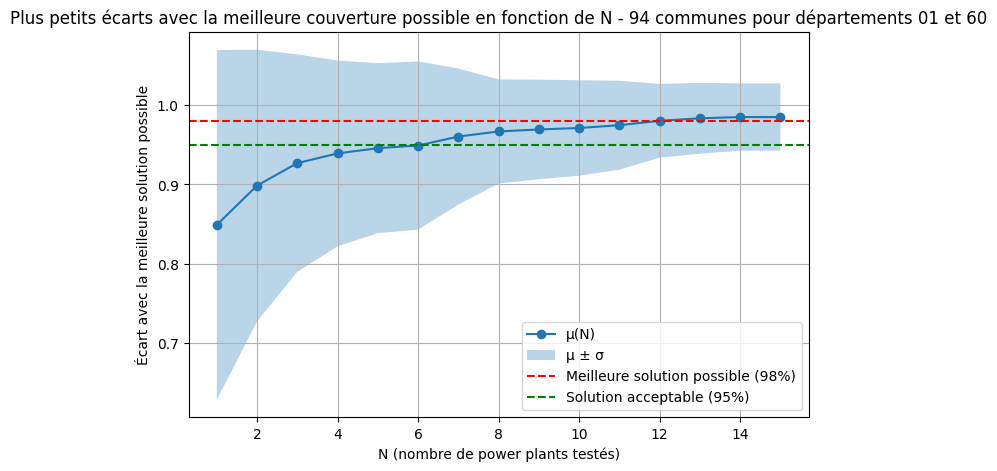

In [188]:
liste_communes_bis=liste_communes+ liste_communes_01+liste_communes_60
#Fustion des dictionnaires de résultats
all_communes_ratio_solution_bis={**all_communes_ratio_solution_01, **all_communes_ratio_solution_60, **all_communes_ratio_solution}
all_communes_coverage_bis={**all_communes_coverage_01, **all_communes_coverage_60, **all_communes_coverage}
all_communes_deltas_bis={**all_communes_deltas_01, **all_communes_deltas_60, **all_communes_deltas}

mu=[0.0 for i in range(15)]
sigma=[0.0 for i in range(15)]
nb_communes=len(liste_communes_bis)
print("Nombre de communes :", nb_communes)

N_max=15
for N in range(1,N_max+1) :
    ratios_N=[]
    
    for commune in liste_communes_bis : 
        ratios=all_communes_ratio_solution_bis[commune]
        ratios_N.append(max(ratios[:N]))
    mu[N-1]=np.mean(ratios_N)
    sigma[N-1]=np.std(ratios_N)

N_values = range(1, N_max + 1)

plt.figure(figsize=(8,5))
plt.plot(N_values, mu, label="μ(N)", marker="o")
plt.fill_between(
    N_values,
    np.array(mu) - np.array(sigma),
    np.array(mu) + np.array(sigma),
    alpha=0.3,
    label="μ ± σ"
)
plt.axhline(y=0.98, color='r', linestyle='--', label="Meilleure solution possible (98%)")
plt.axhline(y=0.95, color='g', linestyle='--', label="Solution acceptable (95%)")
plt.xlabel("N (nombre de power plants testés)")
plt.ylabel("Écart avec la meilleure solution possible")
plt.title(f"Plus petits écarts avec la meilleure couverture possible en fonction de N - {nb_communes} communes pour départements 01 et 60")
plt.legend()
plt.grid(True)
plt.show()


Nombre de communes : 50


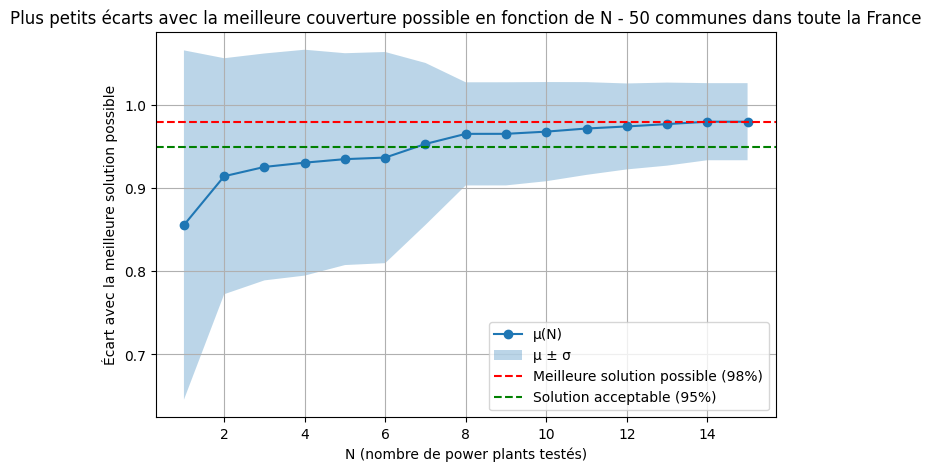

In [190]:

#Liste des communes avec les cles du dictionnaire all_communes_ratio_solution
liste_communes=[elt for elt in all_communes_ratio_solution.keys()]
mu=[0.0 for i in range(15)]
sigma=[0.0 for i in range(15)]
nb_communes=len(liste_communes)
print("Nombre de communes :", nb_communes)

N_max=15
for N in range(1,N_max+1) :
    ratios_N=[]
    
    for commune in liste_communes : 
        ratios=all_communes_ratio_solution[commune]
        ratios_N.append(max(ratios[:N]))
    mu[N-1]=np.mean(ratios_N)
    sigma[N-1]=np.std(ratios_N)

N_values = range(1, N_max + 1)

plt.figure(figsize=(8,5))
plt.plot(N_values, mu, label="μ(N)", marker="o")
plt.fill_between(
    N_values,
    np.array(mu) - np.array(sigma),
    np.array(mu) + np.array(sigma),
    alpha=0.3,
    label="μ ± σ"
)
plt.axhline(y=0.98, color='r', linestyle='--', label="Meilleure solution possible (98%)")
plt.axhline(y=0.95, color='g', linestyle='--', label="Solution acceptable (95%)")
plt.xlabel("N (nombre de power plants testés)")
plt.ylabel("Écart avec la meilleure solution possible")
plt.title(f"Plus petits écarts avec la meilleure couverture possible en fonction de N - {nb_communes} communes dans toute la France")
plt.legend()
plt.grid(True)
plt.show()


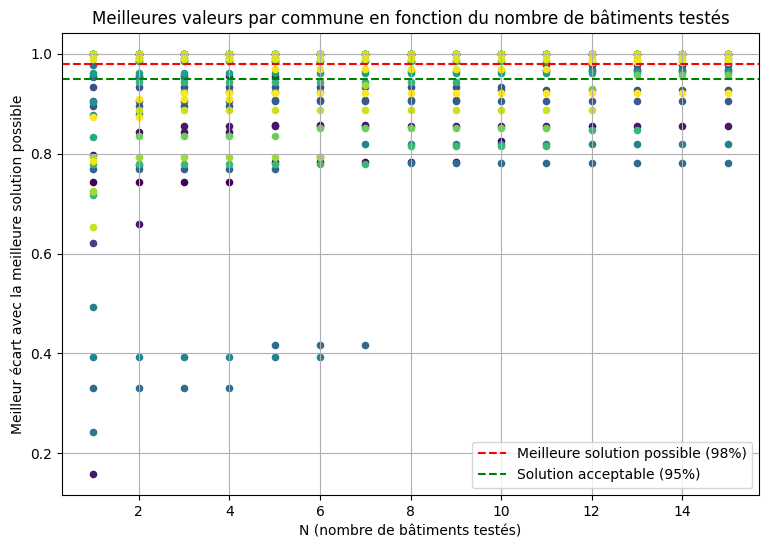

In [192]:
import numpy as np
import matplotlib.pyplot as plt

liste_communes = list(all_communes_ratio_solution.keys())
N_max = 15
N_values = np.arange(1, N_max + 1)

# Une couleur par commune
colors = plt.cm.viridis(np.linspace(0, 1, len(liste_communes)))

plt.figure(figsize=(9,6))

for i, commune in enumerate(liste_communes):
    ratios = all_communes_ratio_solution[commune]
    best_ratios = [max(ratios[:N]) for N in N_values]

    plt.scatter(
        N_values,
        best_ratios,
        color=colors[i],   # ← couleur fixée par commune
        s=20
    )

# Références
plt.axhline(y=0.98, color='r', linestyle='--', label="Meilleure solution possible (98%)")
plt.axhline(y=0.95, color='g', linestyle='--', label="Solution acceptable (95%)")

plt.xlabel("N (nombre de bâtiments testés)")
plt.ylabel("Meilleur écart avec la meilleure solution possible")
plt.title("Meilleures valeurs par commune en fonction du nombre de bâtiments testés")
plt.grid(True)
plt.legend()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

liste_communes = list(all_communes_ratio_solution.keys())
N_max = 15
N_values = np.arange(1, N_max + 1)

# Données pour le boxplot : une liste par N
data_boxplot = []

for N in N_values:
    vals_N = []
    for commune in liste_communes:
        ratios = all_communes_ratio_solution[commune]
        vals_N.append(max(ratios[:N]))
    data_boxplot.append(vals_N)

plt.figure(figsize=(10,6))

plt.boxplot(
    data_boxplot,
    positions=N_values,
    widths=0.6,
    #enlever outiliers
    showfliers=False

)

# Références
plt.axhline(y=0.98, color='r', linestyle='--', label="Meilleure solution possible (98%)")
plt.axhline(y=0.95, color='g', linestyle='--', label="Solution acceptable (95%)")

plt.xlabel("N (nombre de bâtiments testés)")
plt.ylabel("Meilleur écart avec la meilleure solution possible")
plt.title("Distribution des meilleures valeurs par commune en fonction de N")
plt.grid(True, axis="y")
plt.legend()

plt.show()


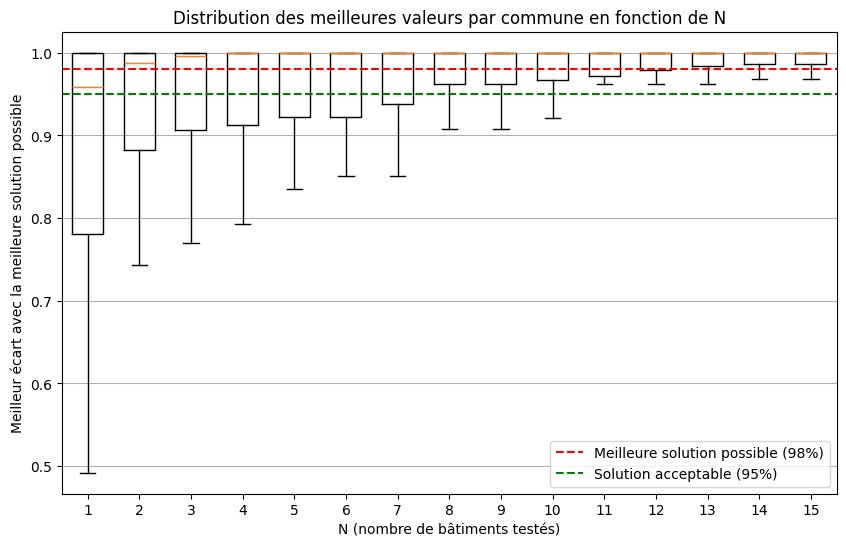

IndexError: list index out of range

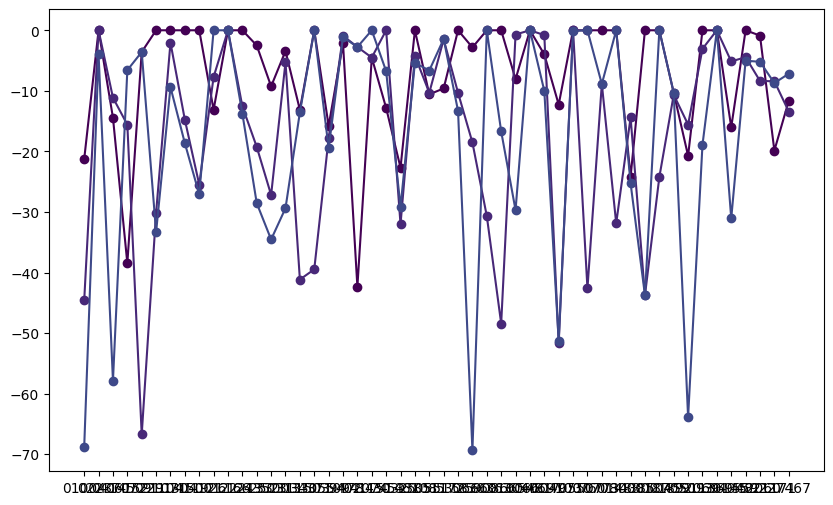

In [180]:
plt.figure(figsize=(10, 6))
#array de 10 couleurs
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i in range(10):
    data = [all_communes_deltas[commune][i] for commune in all_communes_deltas.keys()]
    plt.plot(list(all_communes_deltas.keys()), data, marker='o', linestyle='-', color=colors[i], label=f'Bâtiment initial {i+1}')

plt.axhline(y=-5, color='r', linestyle='--', label='Seuil 5%')
plt.xlabel('Communes')
plt.ylabel('Delta de couverture (%)')
plt.title(f'Delta de couverture en fonction du choix du bâtiment initial - {departement} {nom_departement}')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(5):
    data = [all_communes_deltas[commune][i] for commune in all_communes_deltas.keys()]
    plt.plot(list(all_communes_deltas.keys()), data, marker='o', linestyle='-', color=colors[i], label=f'Bâtiment initial {i+1}')
plt.axhline(y=-5, color='r', linestyle='--', label='Seuil 5%')

plt.xlabel('Communes')
plt.ylabel('Delta de couverture (%)')
plt.title(f'Delta de couverture en fonction du choix du bâtiment initial - {departement} {nom_departement}')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(6):
    data = [all_communes_deltas[commune][i] for commune in all_communes_deltas.keys()]
    plt.plot(list(all_communes_deltas.keys()), data, marker='o', linestyle='-', color=colors[i], label=f'Bâtiment initial {i+1}')
plt.axhline(y=-5, color='r', linestyle='--', label='Seuil 5%')

plt.xlabel('Communes')
plt.ylabel('Delta de couverture (%)')
plt.title(f'Delta de couverture en fonction du choix du bâtiment initial - {departement} {nom_departement}')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'code_commune_insee' is not defined

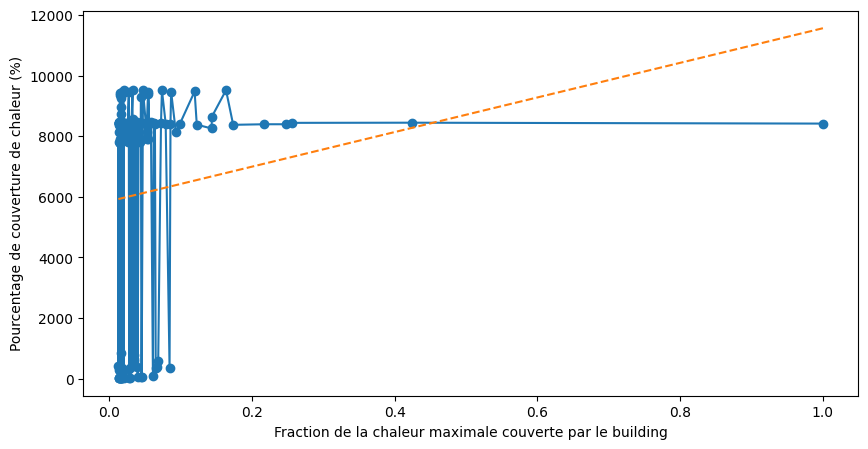

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Données
highest_consumption=liste_nodes_buildings[0].heat_demand

Percentage_energy_building=[buildings.heat_demand / highest_consumption for buildings in liste_nodes_buildings ]

idx_plants=[i for i in range(len(liste_nodes_buildings))]

Percentage_heat_coverage = [
    dico_results[i]["percentage_heat_demand_connected"] * 100 for i in idx_plants
]

x = np.array(Percentage_energy_building)
y = np.array(Percentage_heat_coverage)

# Régression linéaire
a, b = np.polyfit(x, y, 1)
y_reg = a * x + b

# Calcul du R²
ss_res = np.sum((y - y_reg) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(
    Percentage_energy_building,
    y,
    marker='o',
    label='Pourcentage de couverture de chaleur (%)'
)

ax1.plot(
    Percentage_energy_building,
    y_reg,
    linestyle='--',
    label='Régression linéaire'
)

ax1.set_xlabel('Fraction de la chaleur maximale couverte par le building')
ax1.set_ylabel('Pourcentage de couverture de chaleur (%)')
ax1.set_title(
    f'Pourcentage de couverture de chaleur en fonction du bâtiment central - Commune {code_commune_insee}'
)

# Affichage pente + R²
ax1.text(
    0.02, 0.95,
    f'Pente : {a:.2f}\nR² : {r2:.3f}',
    transform=ax1.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', alpha=0.3)
)

ax1.legend()
plt.tight_layout()
plt.show()
